# Chapter 6: EDA of the aging problem

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-paper')
plt.rc('text', usetex=False)

# 0. Load raw data

In [105]:
df = pd.read_csv('../../data/aging_data.csv', header=0, index_col=0)
df.head()

,gender,age,CO-Pyr/Mal,CO-Succinate,ATP-Pyr/Mal,ATP-Succinate,PO-Pyr/Mal,PO-Succinate,ATP,AMP,ATP/AMP,MDA,LDH
campione,,,,,,,,,,,,,
#271/2016,f,9,6.53,9.18,20.642016,10.120000,3.161105,1.102397,0.289389,0.072347,4.000000,1.961658,202.572347
#08/2017,m,8,11.42,8.16,30.920777,11.240000,2.707599,1.377451,0.281350,0.096463,2.916667,0.624164,144.694534
#250/2016,m,10,18.56,11.73,43.274765,23.303857,2.331615,1.986689,0.273312,0.080386,3.400000,1.515827,192.926045
#251/2016,f,10,17.94,11.79,51.199060,23.508654,2.853905,1.993949,0.321543,0.088424,3.636364,0.624164,185.423365
#252/2016,m,10,16.83,11.32,34.307632,18.547368,2.038481,1.638460,0.265273,0.060289,4.400000,1.069996,197.213290


In [125]:
for c in df.columns:
    print('{}: missing {}'.format(c, np.count_nonzero(df[c].isnull())))
print(df.shape)
print(df.dropna().shape)

gender: missing 2
age: missing 0
CO-Pyr/Mal: missing 0
CO-Succinate: missing 0
ATP-Pyr/Mal: missing 0
ATP-Succinate: missing 0
PO-Pyr/Mal: missing 0
PO-Succinate: missing 0
ATP: missing 0
AMP: missing 0
ATP/AMP: missing 0
MDA: missing 0
LDH: missing 7
(118, 13)
(111, 13)


# 1. Show some basic statistics

118 subjects
8 - 106


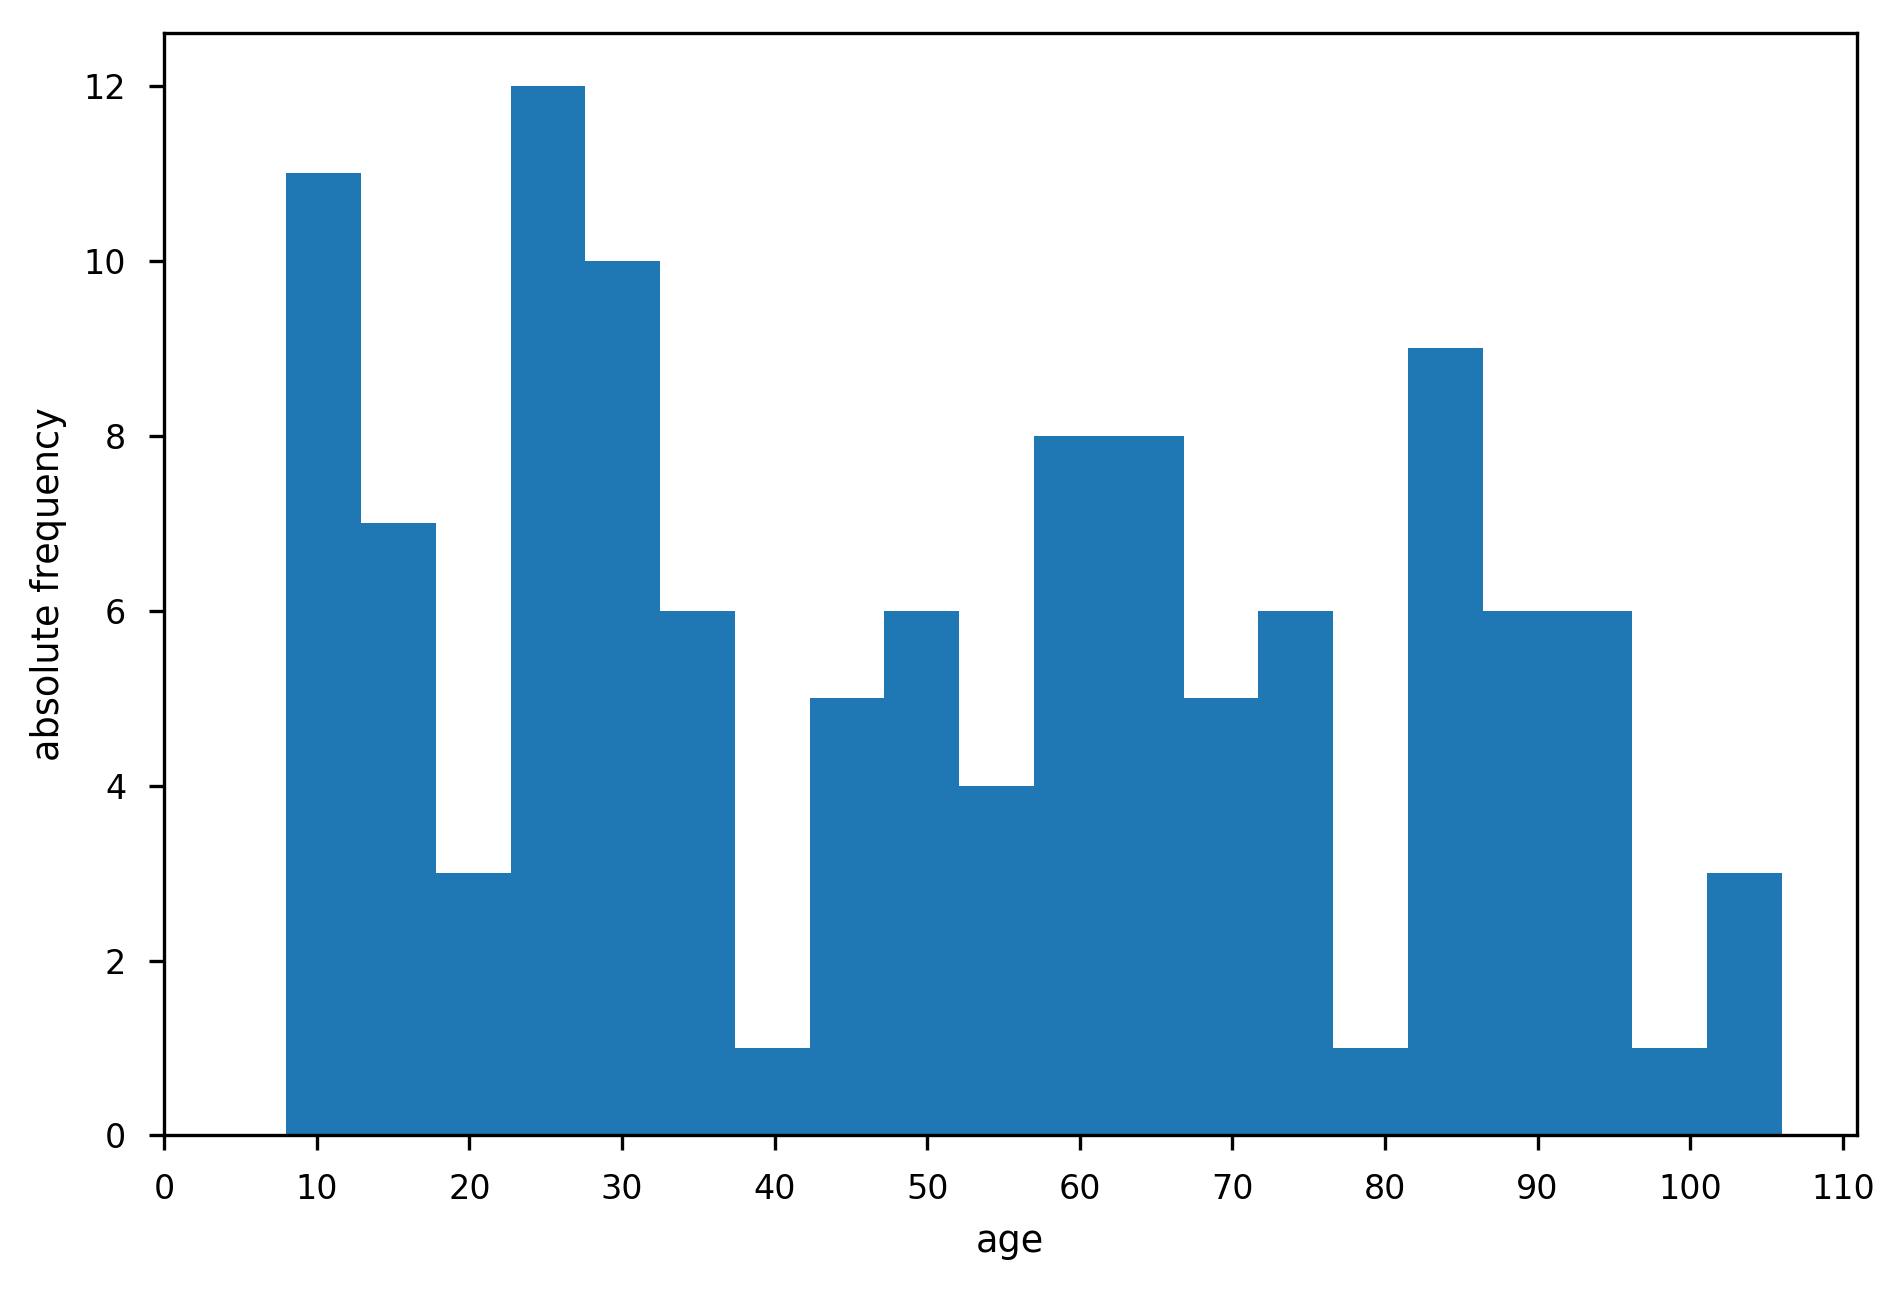

In [30]:
# Plot the histogram of the ages
plt.figure(dpi=300)

plt.hist(df['age'], bins=20)
plt.xlabel('age')
plt.ylabel('absolute frequency')
plt.tight_layout()
plt.xticks(np.arange(0,120,10), np.arange(0,120,10))

plt.savefig('../../images/aging_agehist.png');

print('{} subjects'.format(len(df['age'])))
print('{} - {}'.format(df['age'].min(), df['age'].max()))

In [31]:
# Make the boxplots per decade
def group_boxplot(X, y):        
    group_ages = np.arange(1, 120, 10)
    Xg = [] # grouped X
    for g in group_ages[1:]:
        idx = np.where(np.logical_and(y >= g-10, y < g))[0]
        if len(idx)>0:
            Xg.append(X[idx])
        else:
            Xg.append([None])
    return Xg

In [32]:
columns = df.columns.drop(['age', 'gender'])
X, y = df[columns], df['age']

In [33]:
# fixing the units of measurements
units = {}
units['ATP'] = r'mM/ml'
units['AMP'] = units['ATP']
units['ATP/AMP'] = '' # this is just a number
units['CO-Pyr/Mal'] = r'nmol O$_2$/(min $\cdot$ mg)'
units['CO-Succinate'] = units['CO-Pyr/Mal']
units['ATP-Pyr/Mal'] = r'nmol ATP/(min $\cdot$ mg)'
units['ATP-Succinate'] = units['ATP-Pyr/Mal']
units['PO-Pyr/Mal'] = r'nmol ATP/nmol O$_2$'
units['PO-Succinate'] = units['PO-Pyr/Mal']
units['LDH'] = r'U/mg'
units['MDA'] = r'$\mu$M/ml'

In [34]:
xticks = ['0-10', '11-20', '21-30',
          '31-40', '41-50', '51-60',
          '61-70', '71-80', '81-90',
          '91-100', '>100']

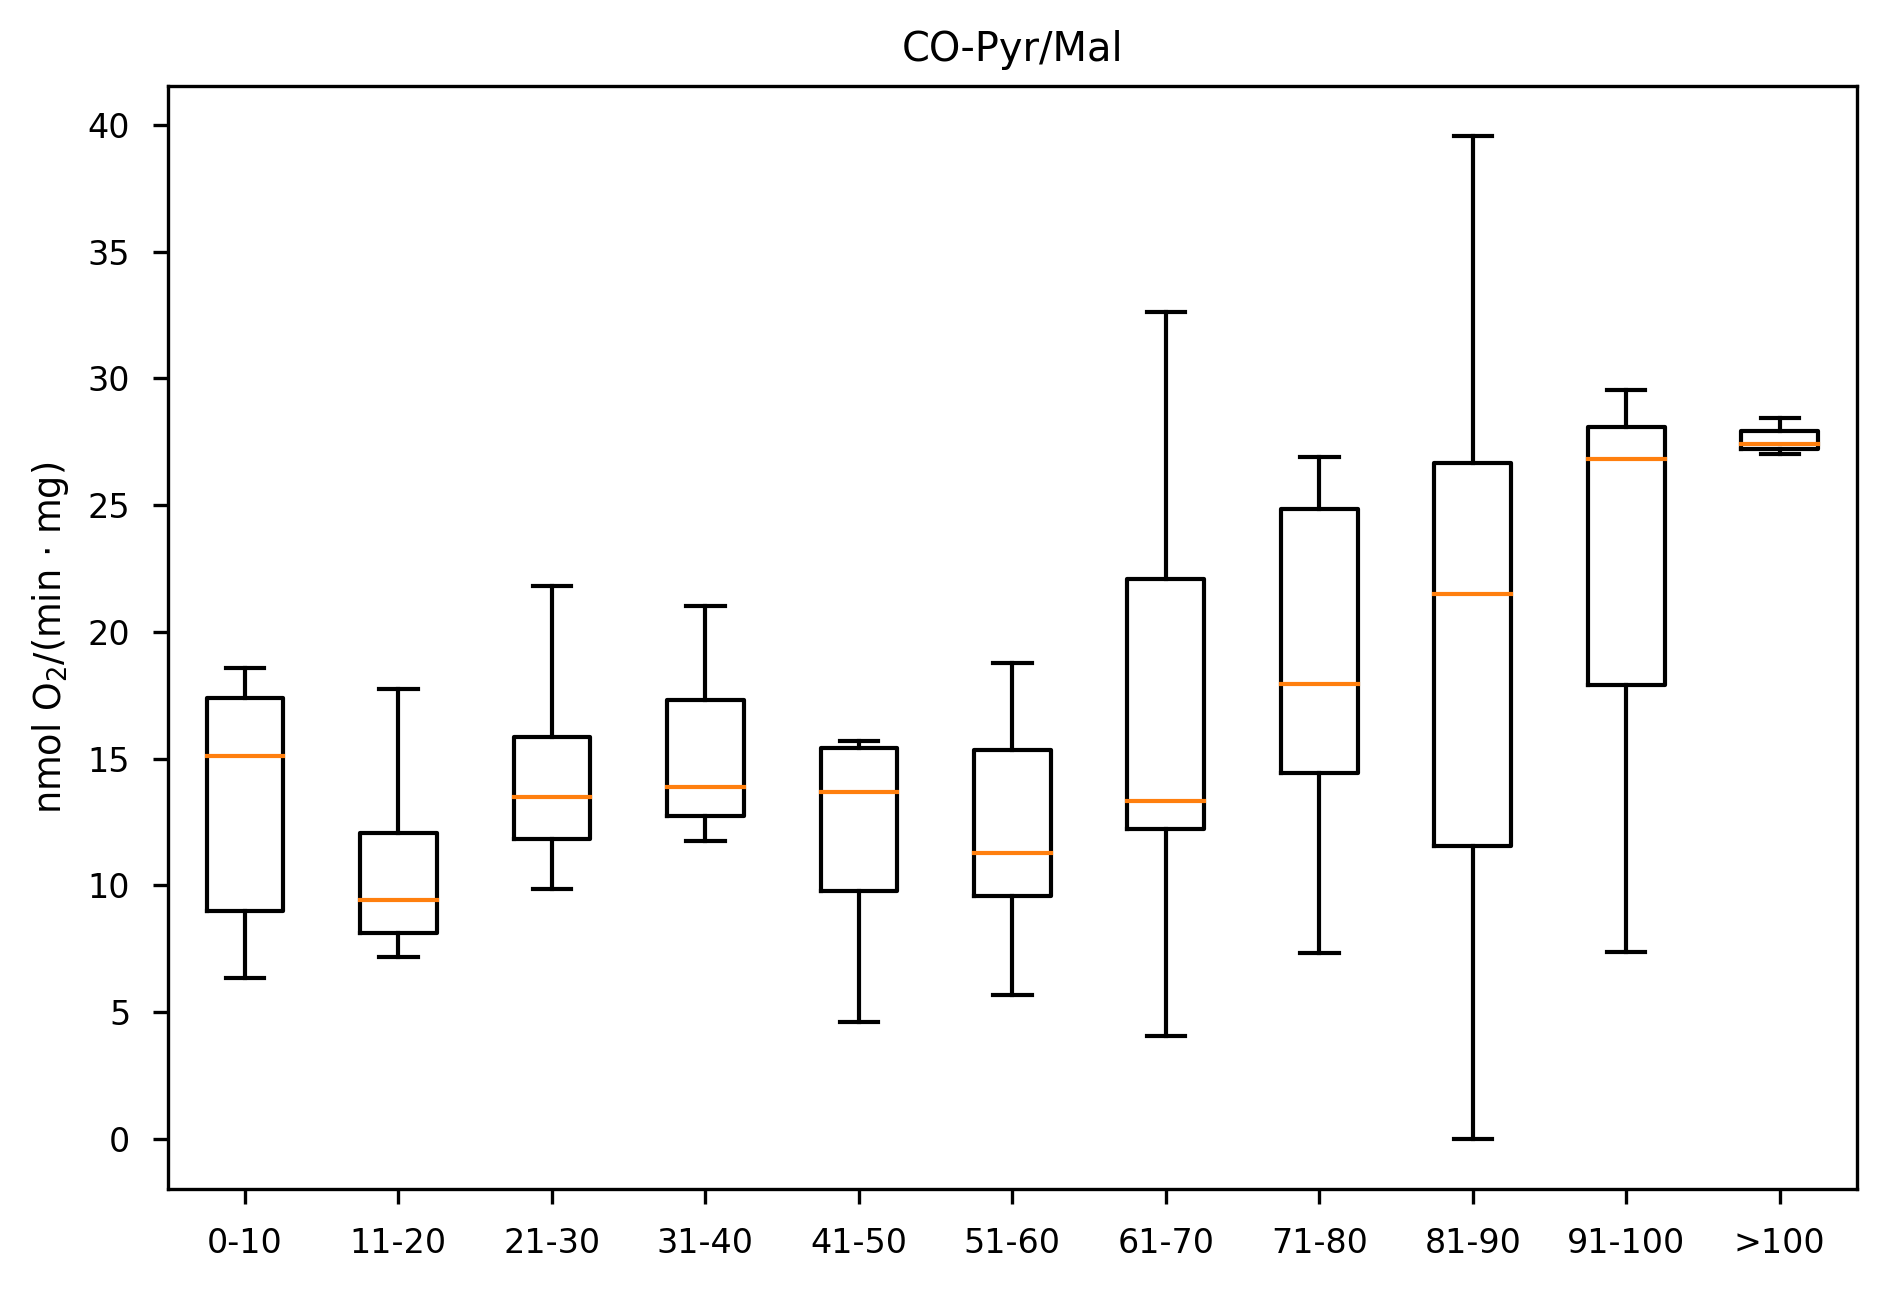

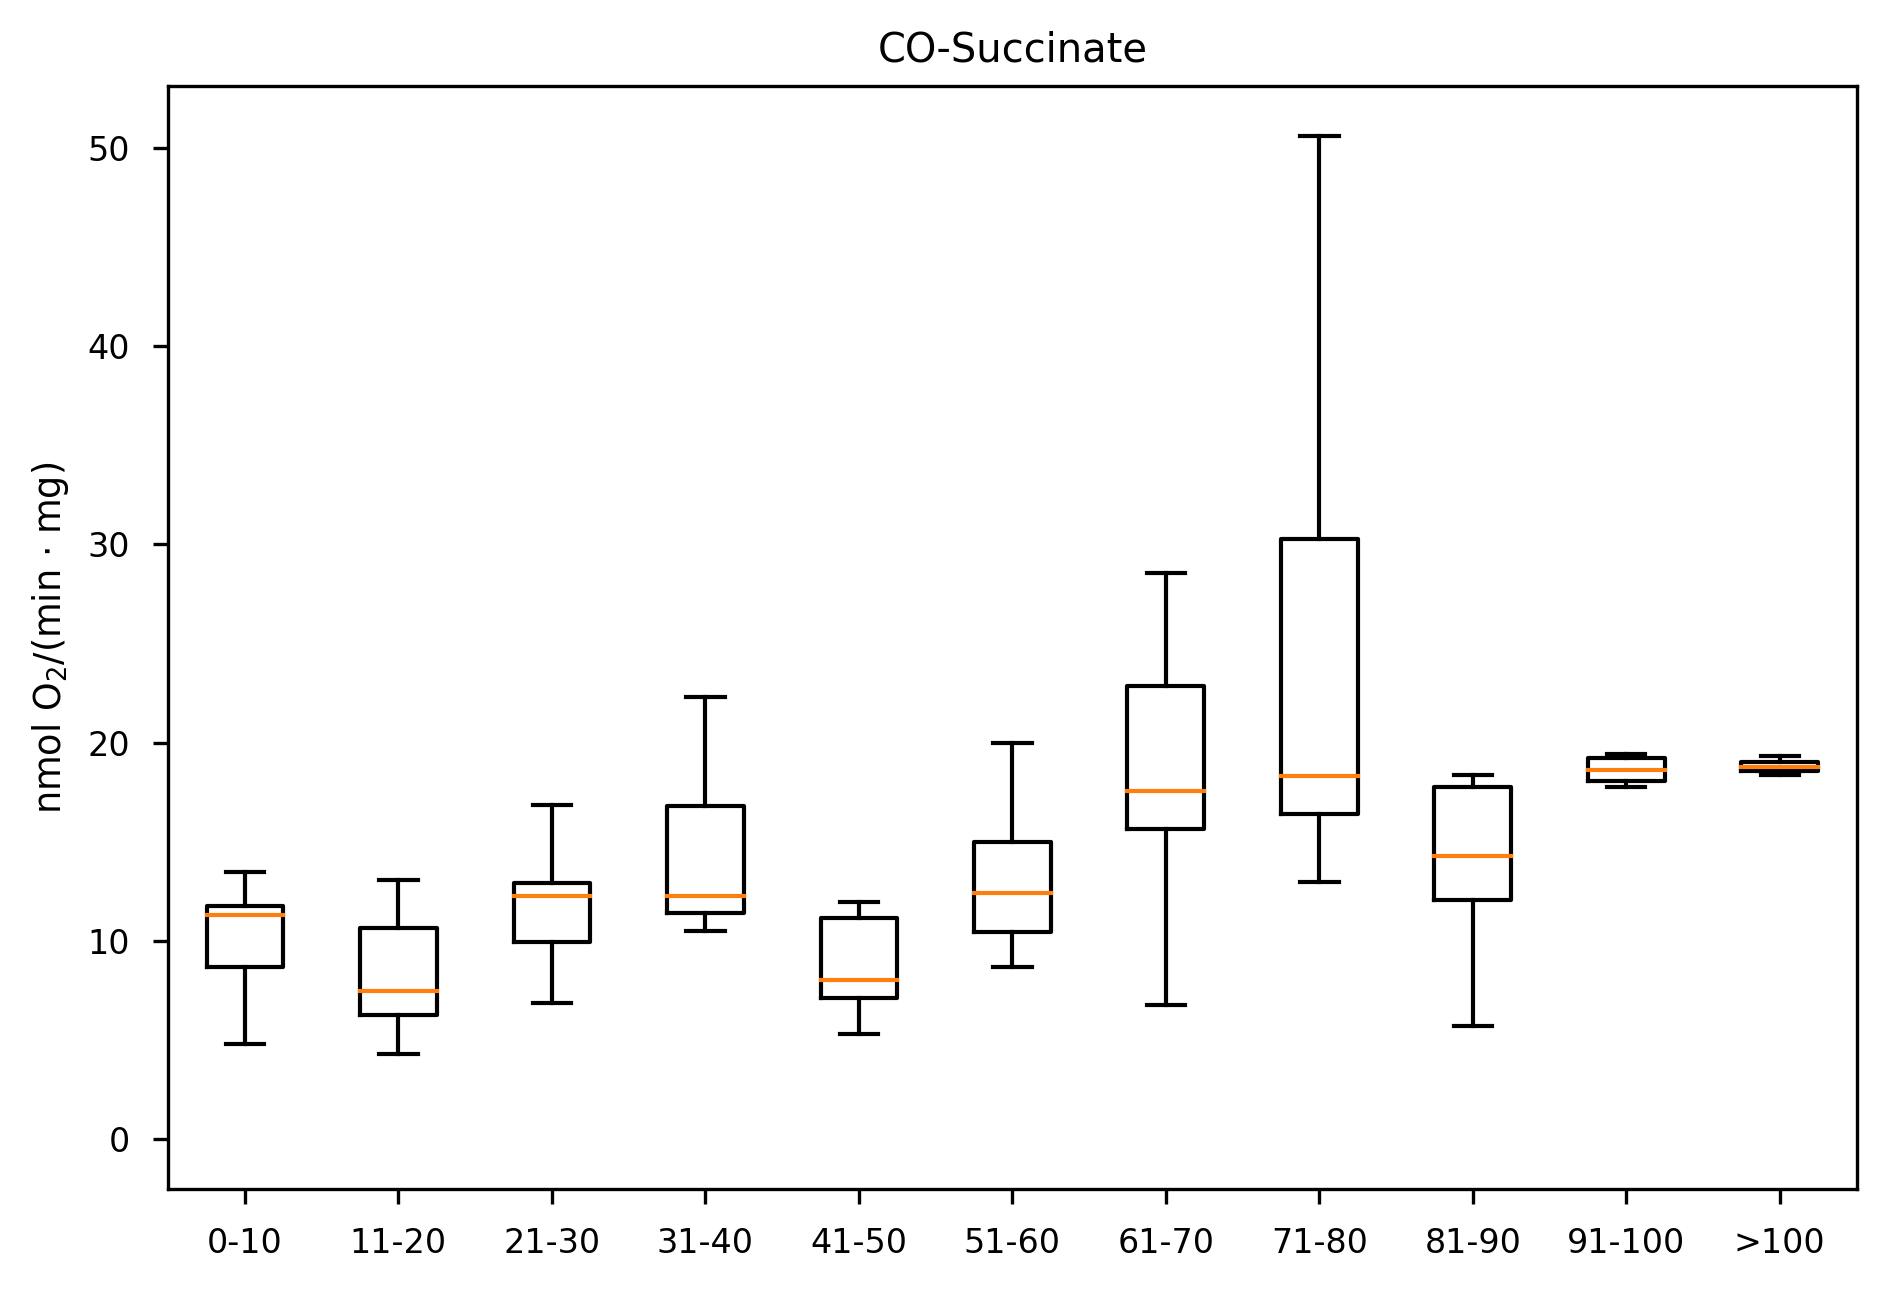

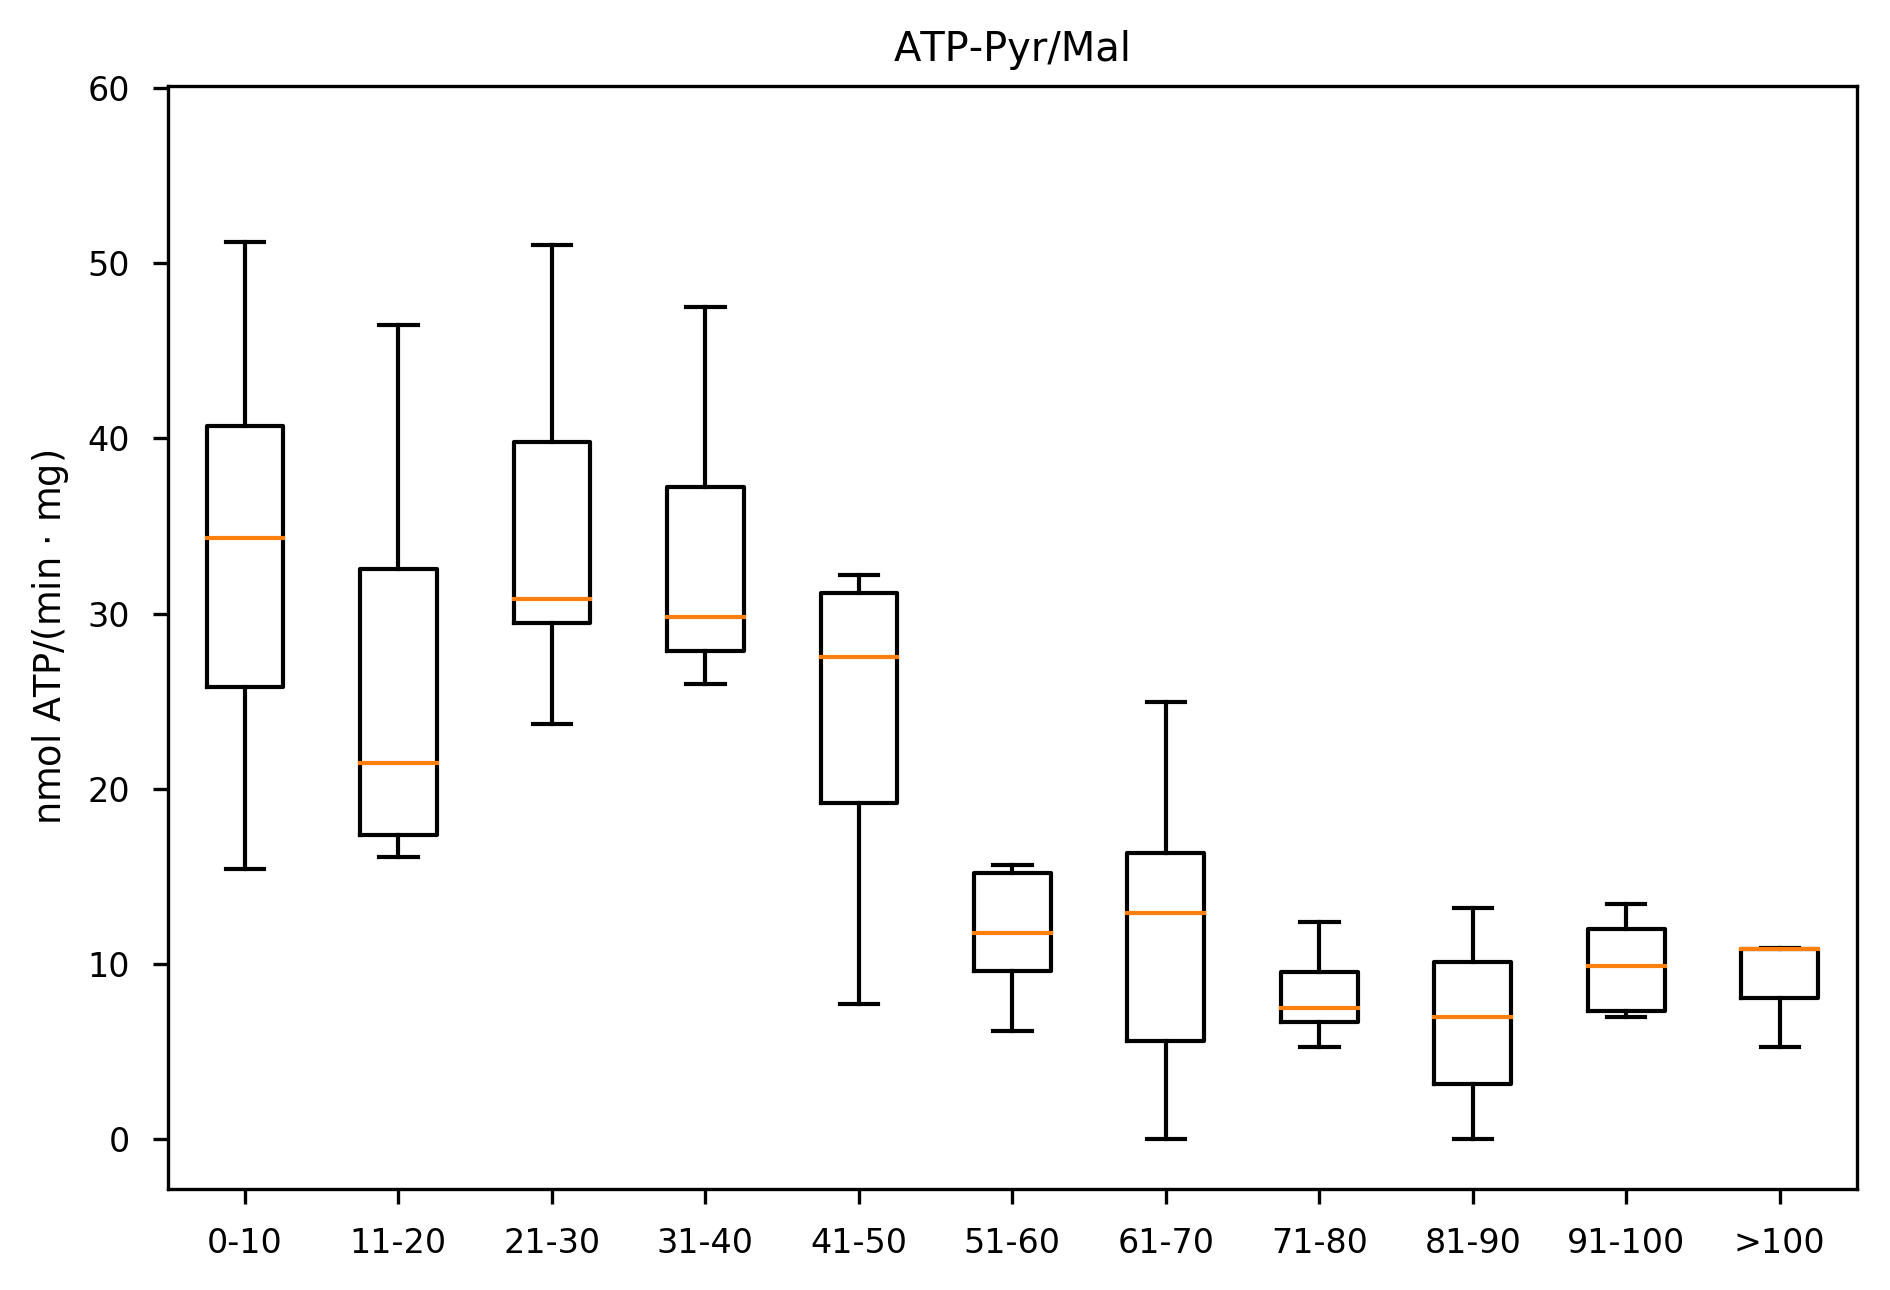

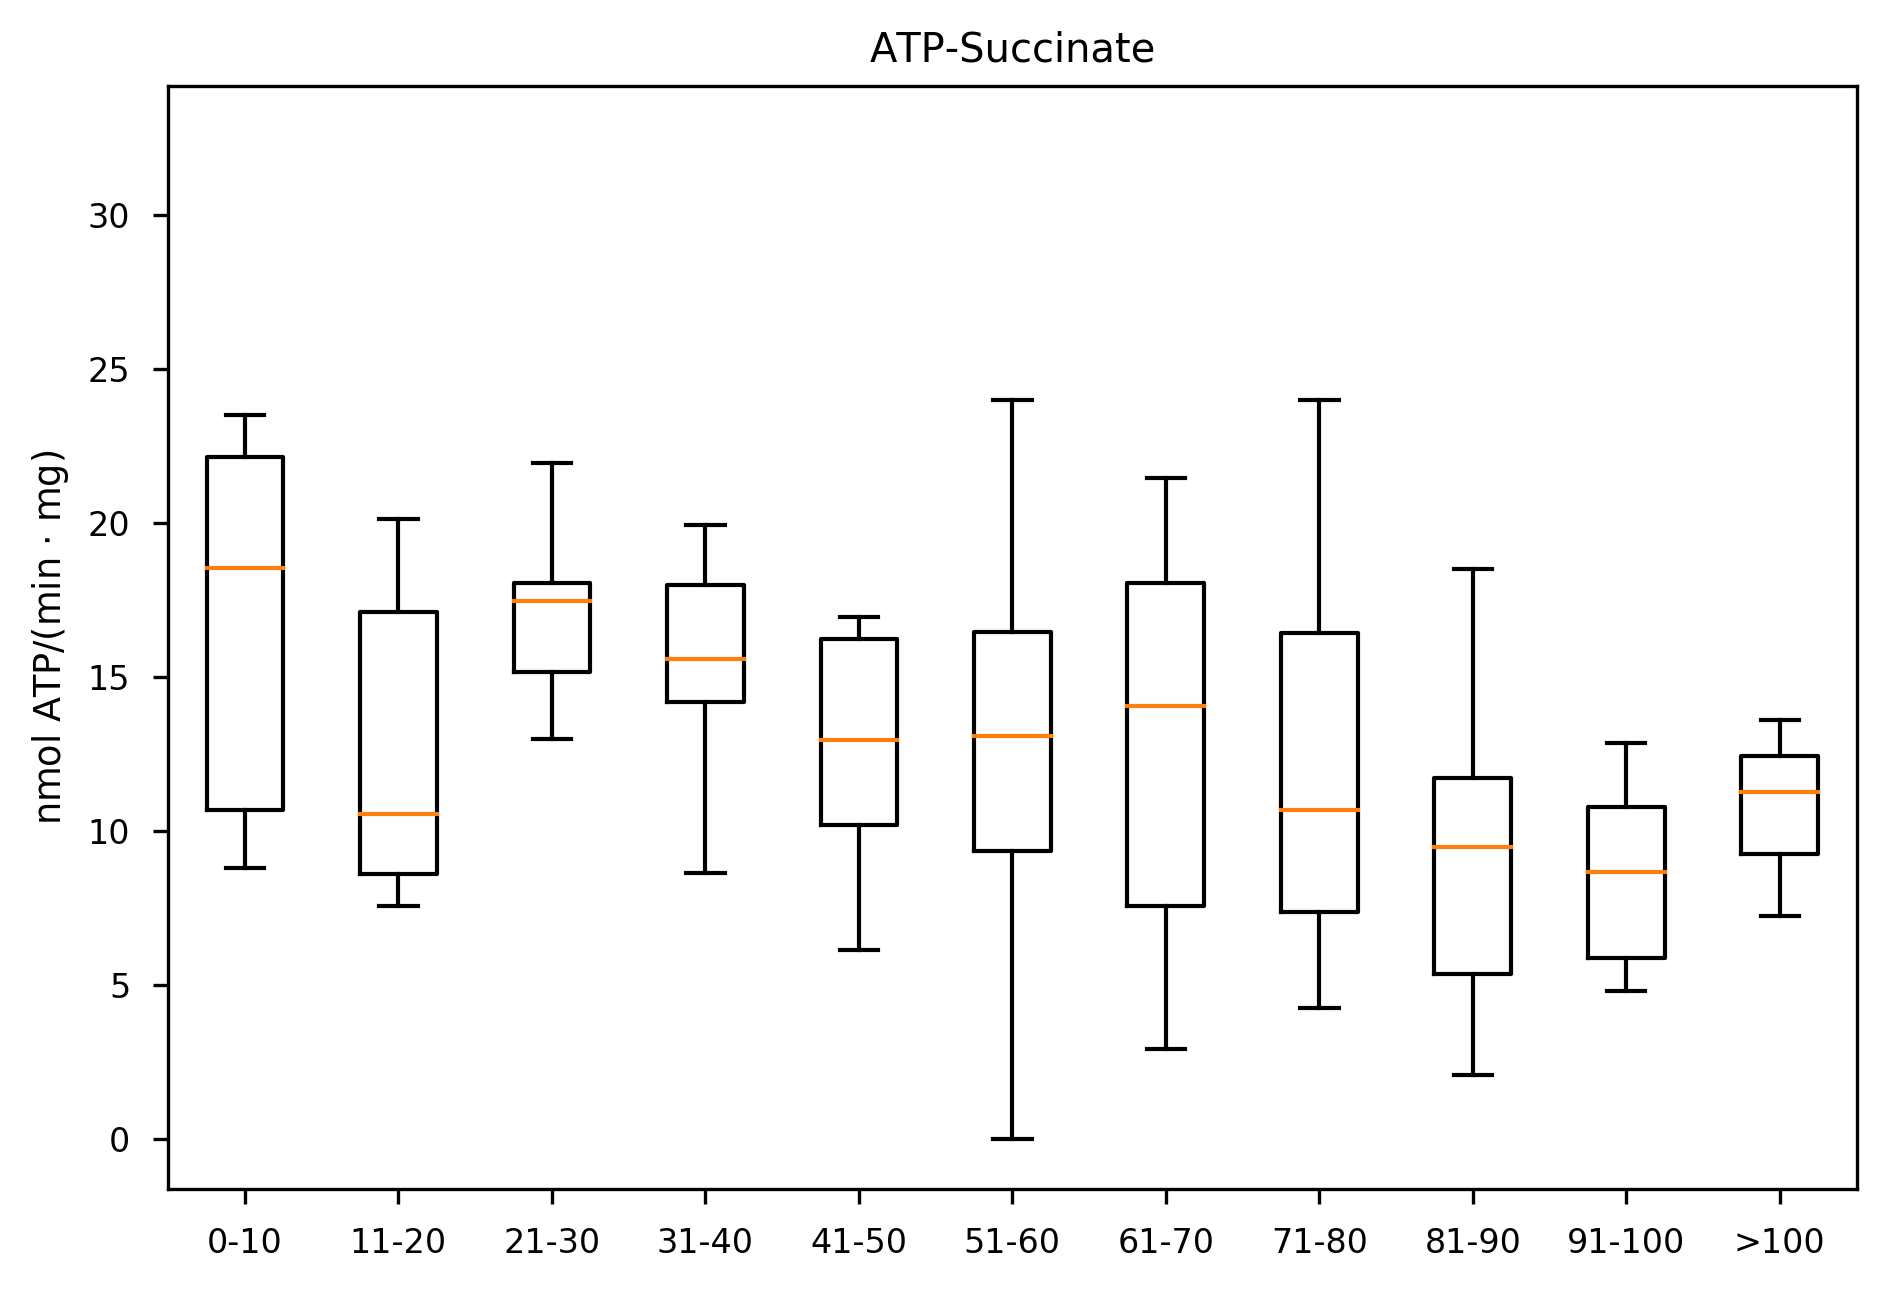

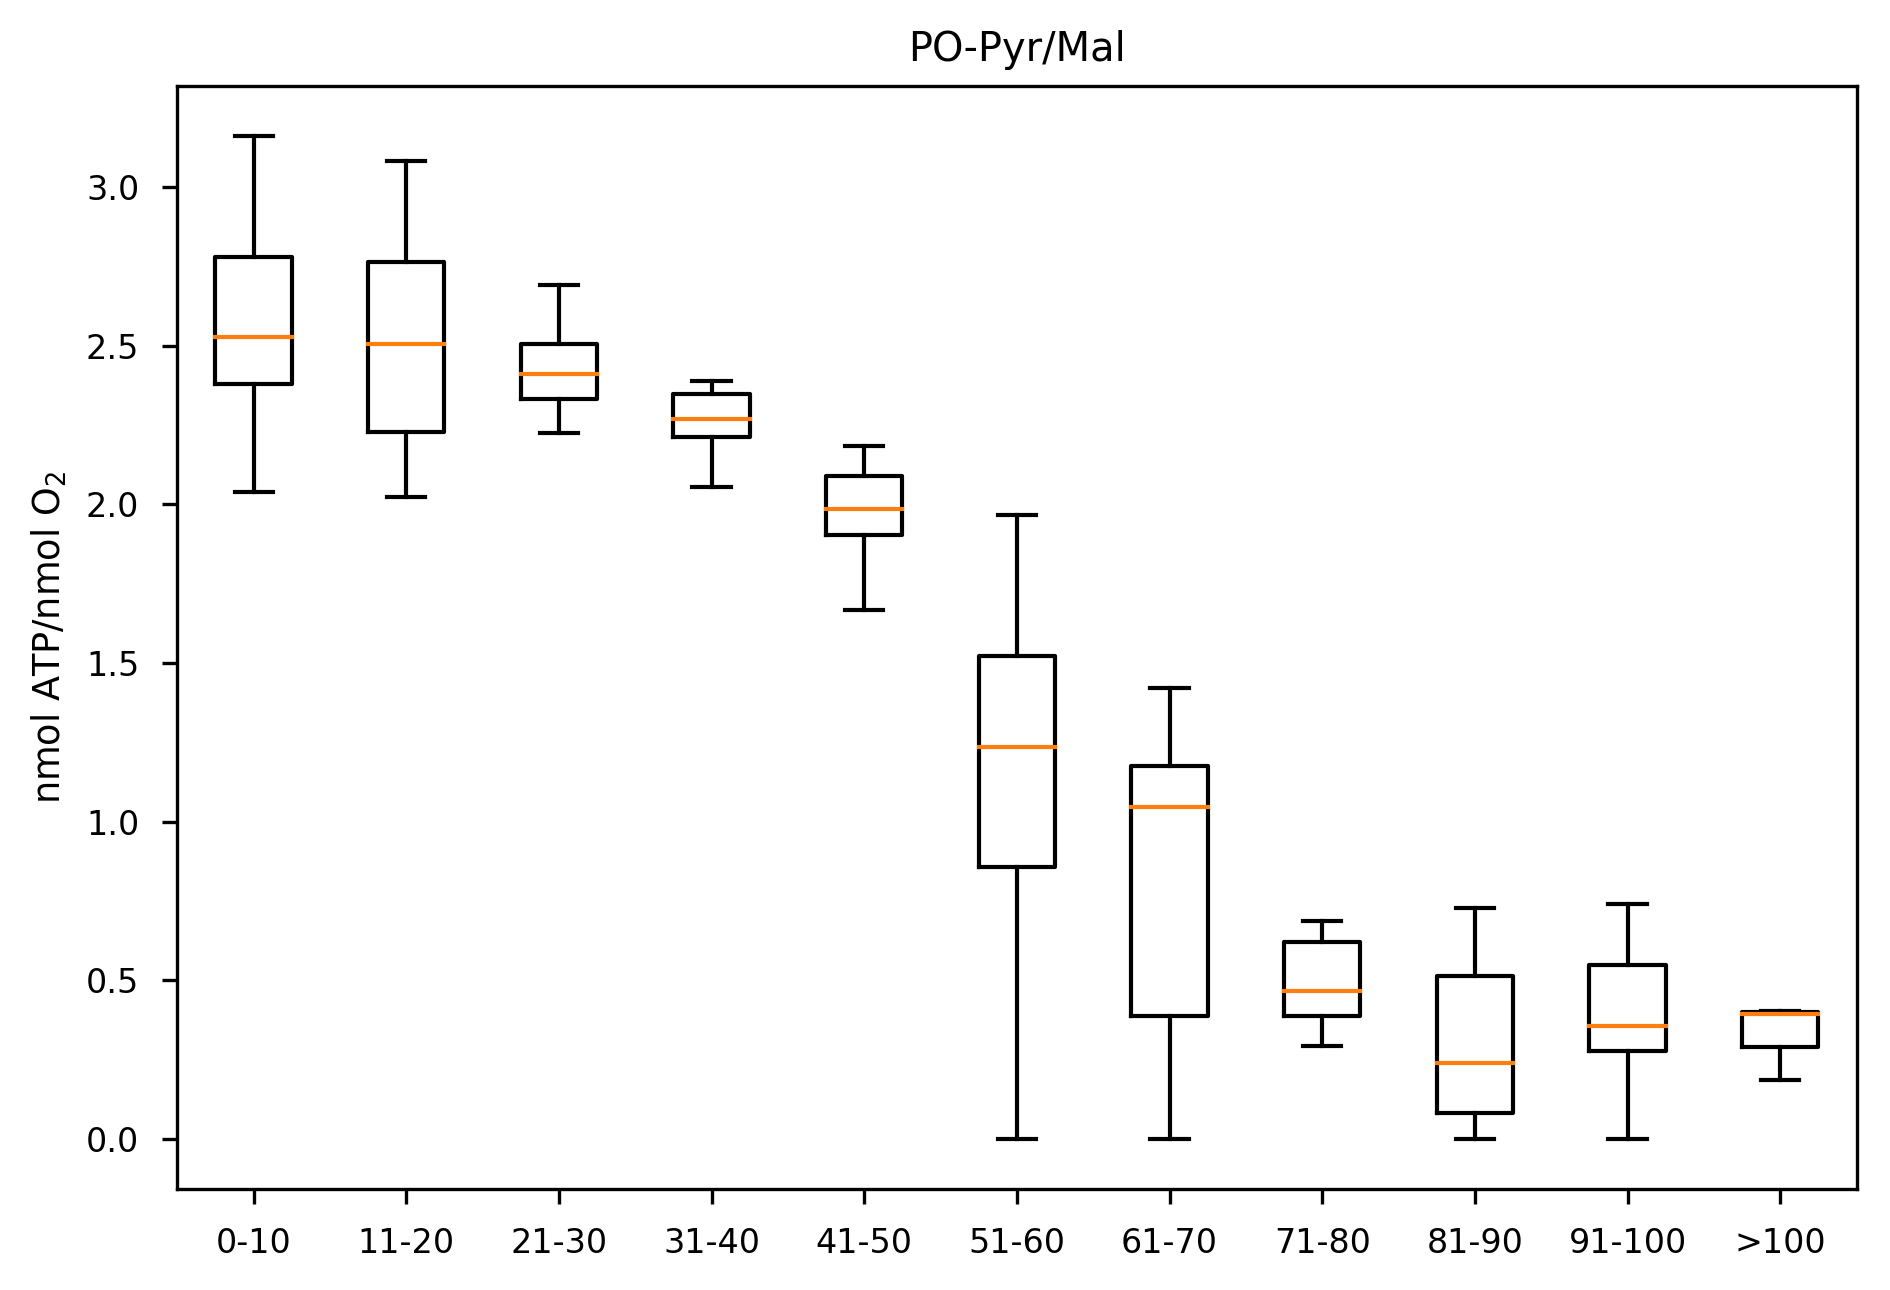

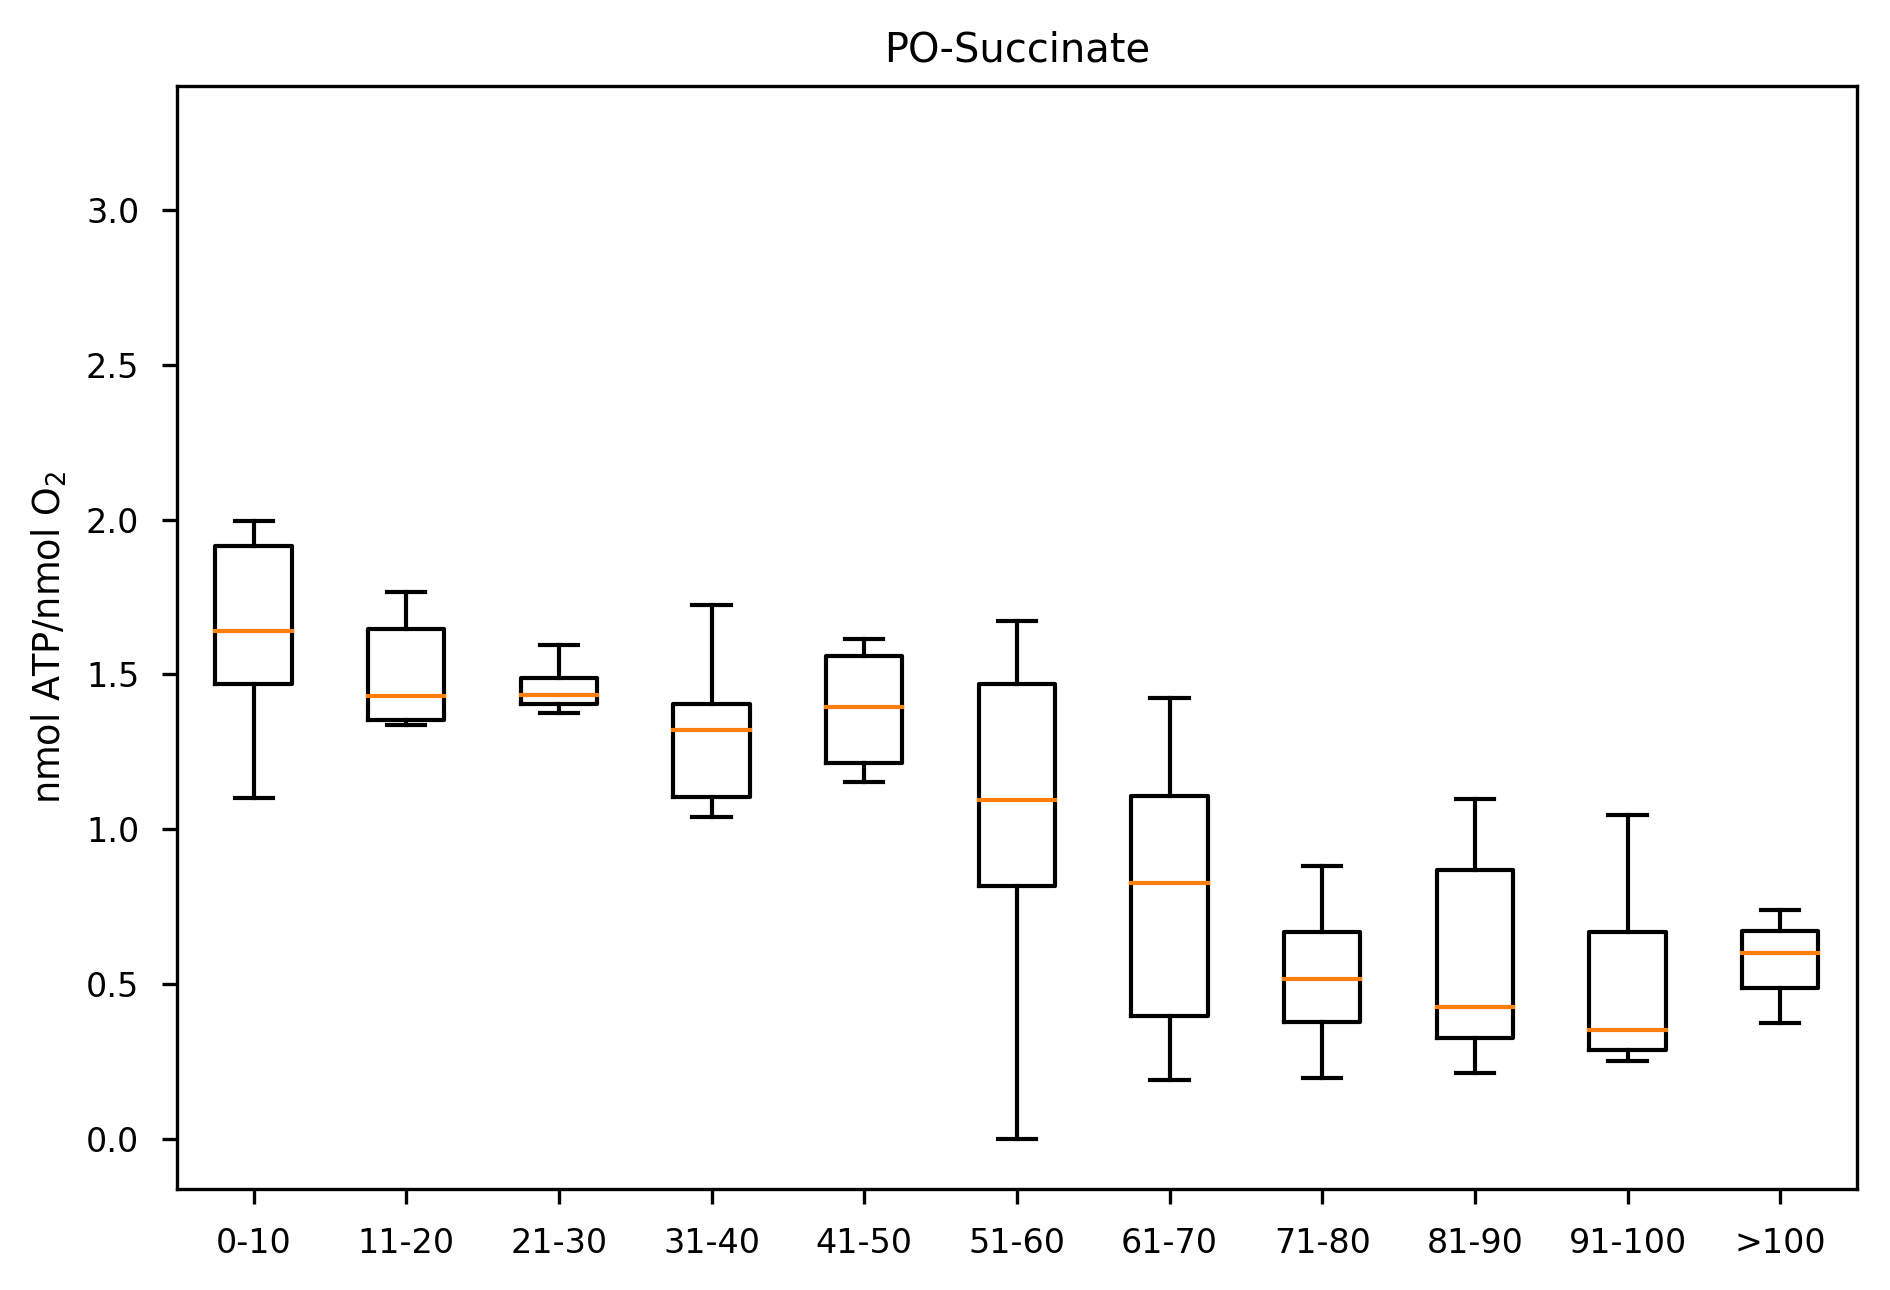

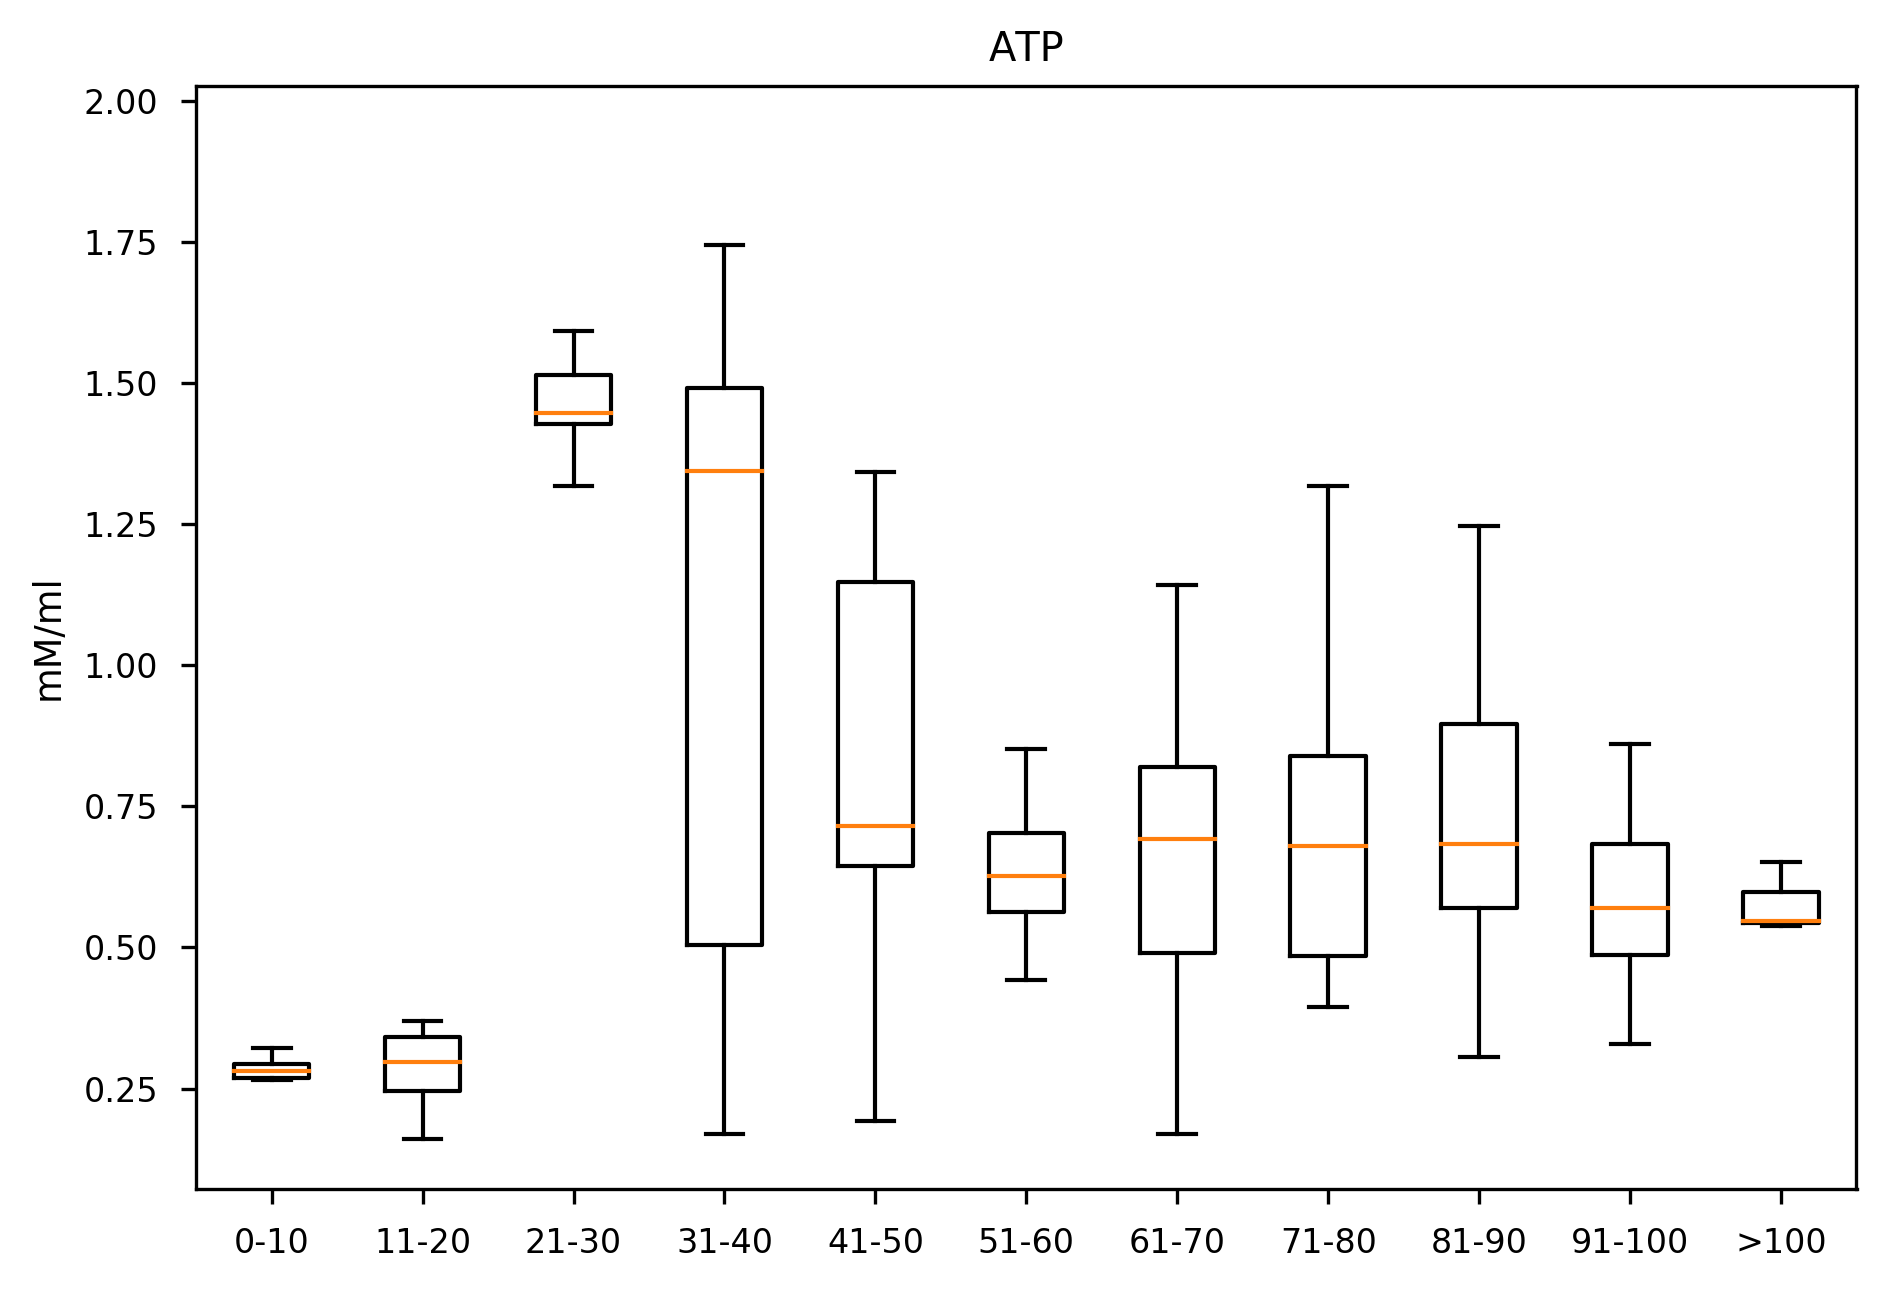

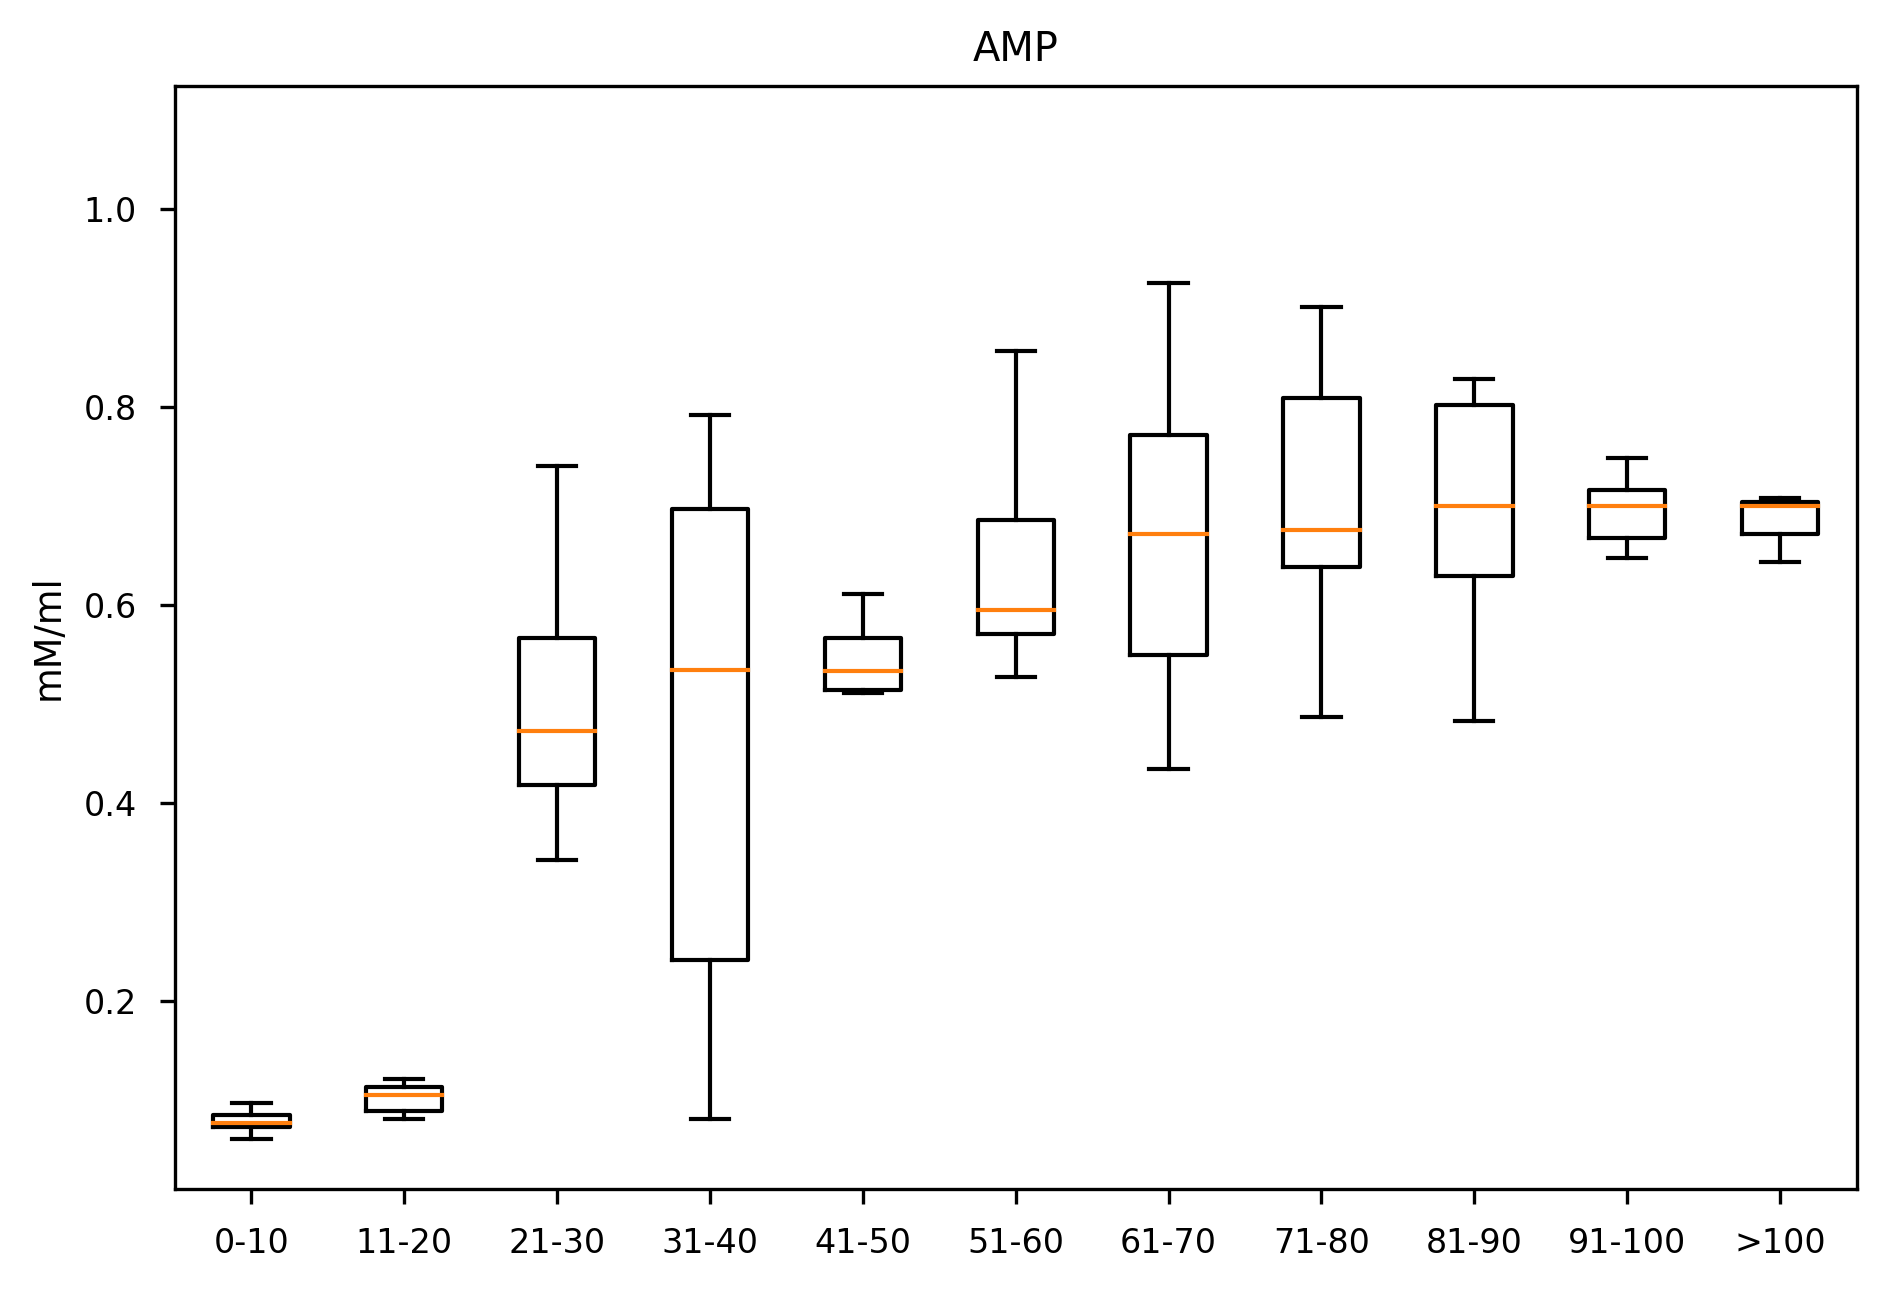

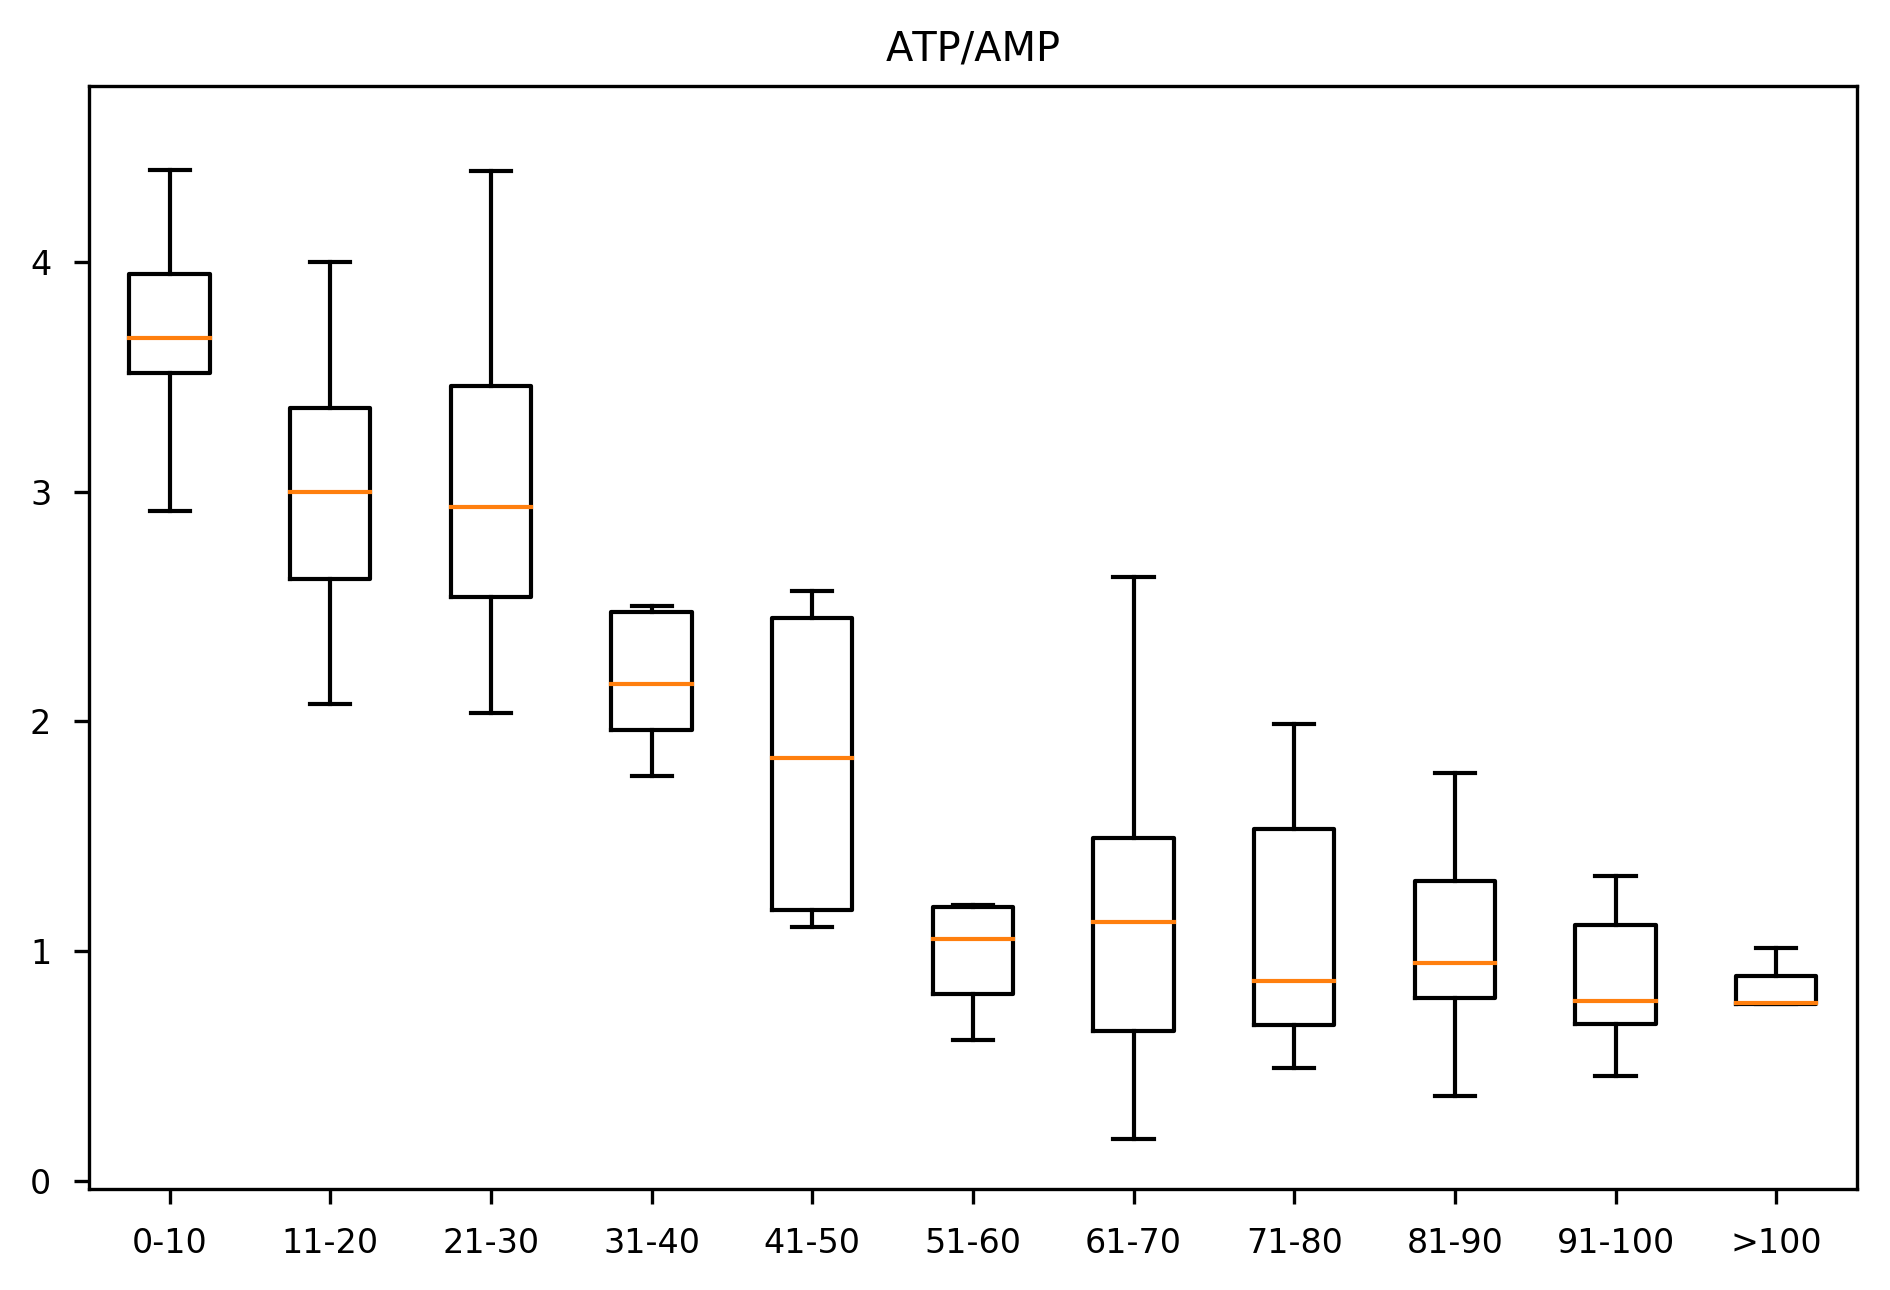

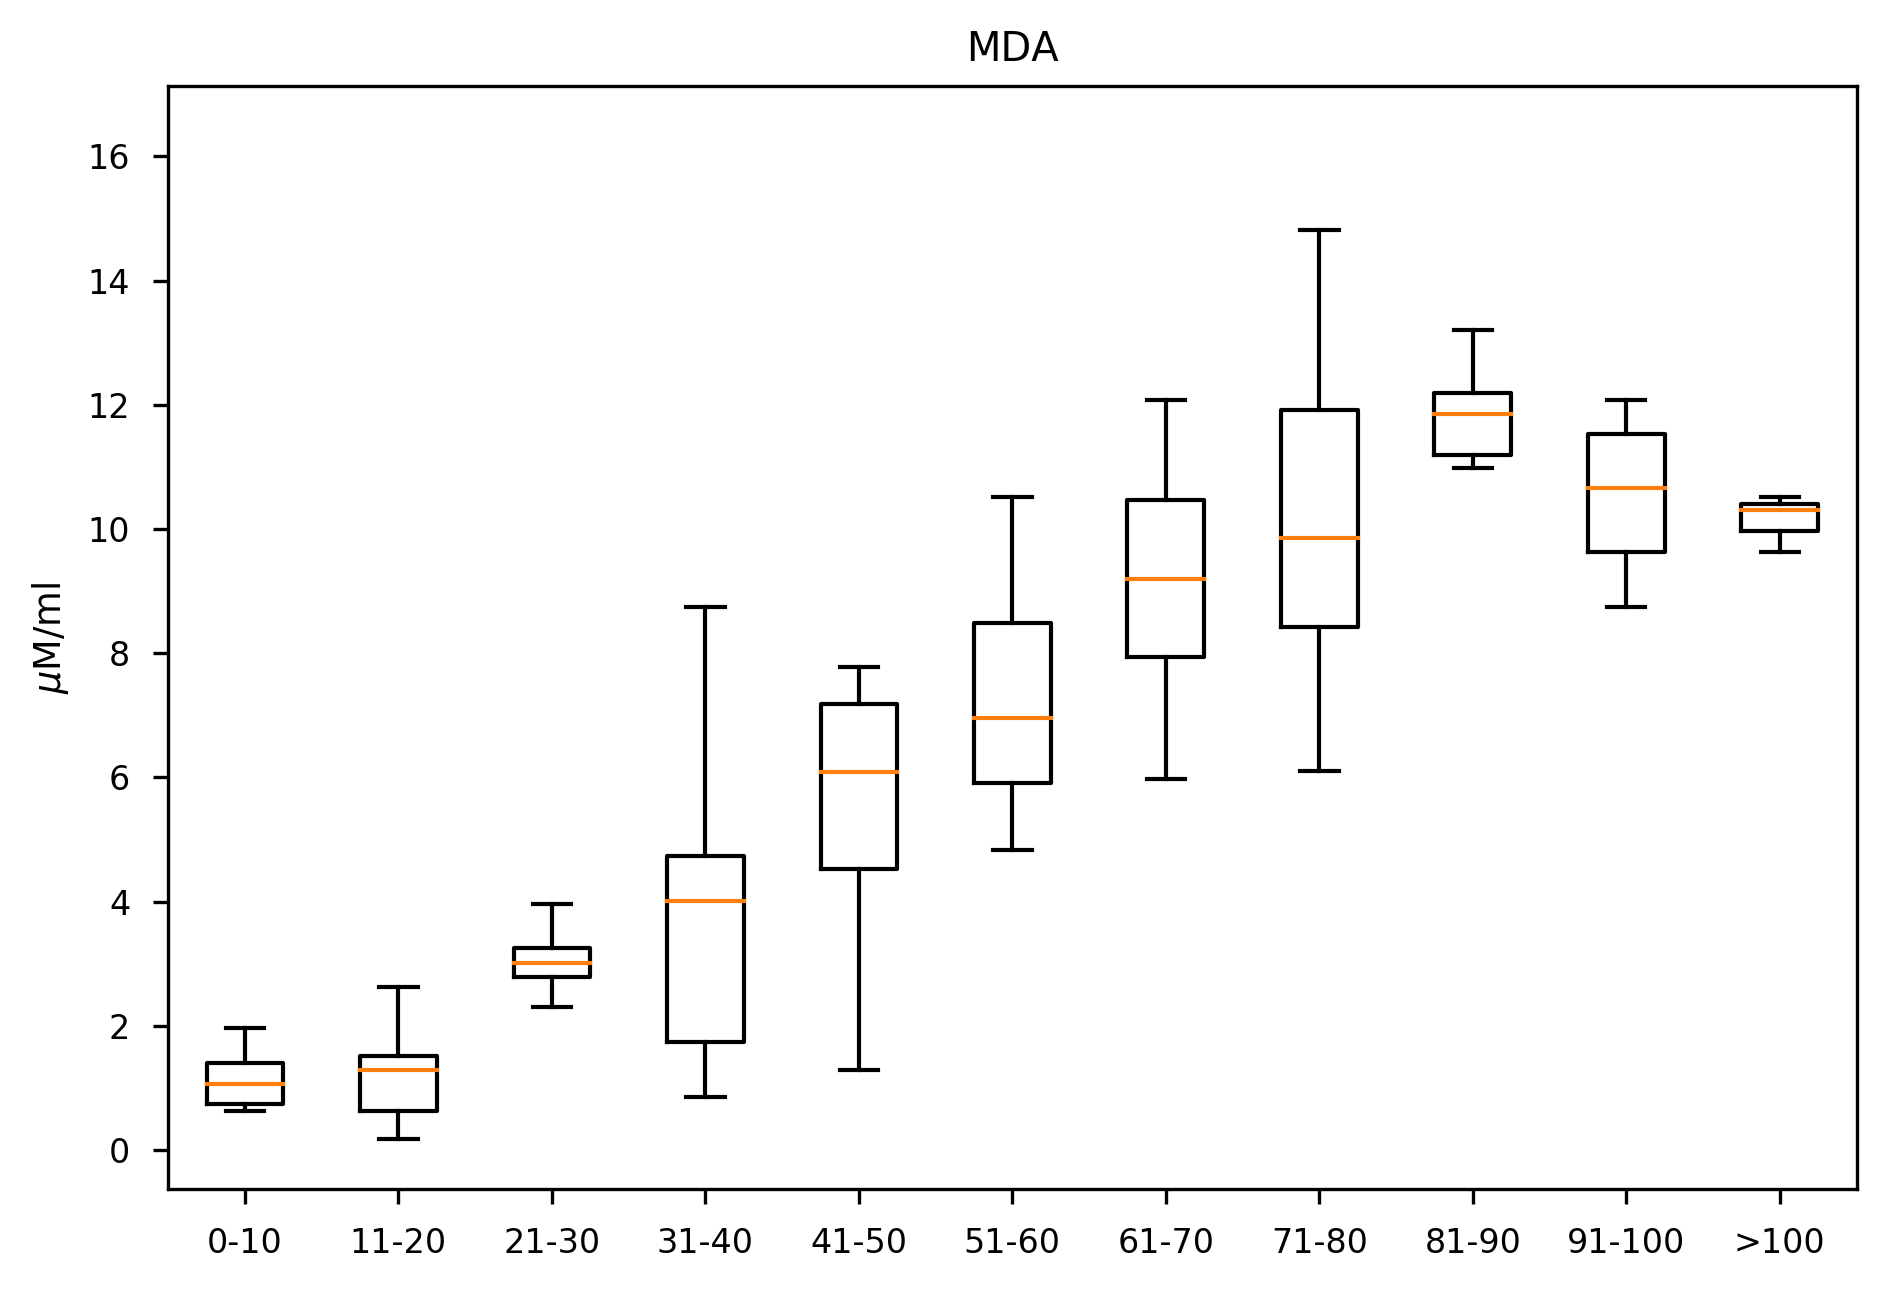

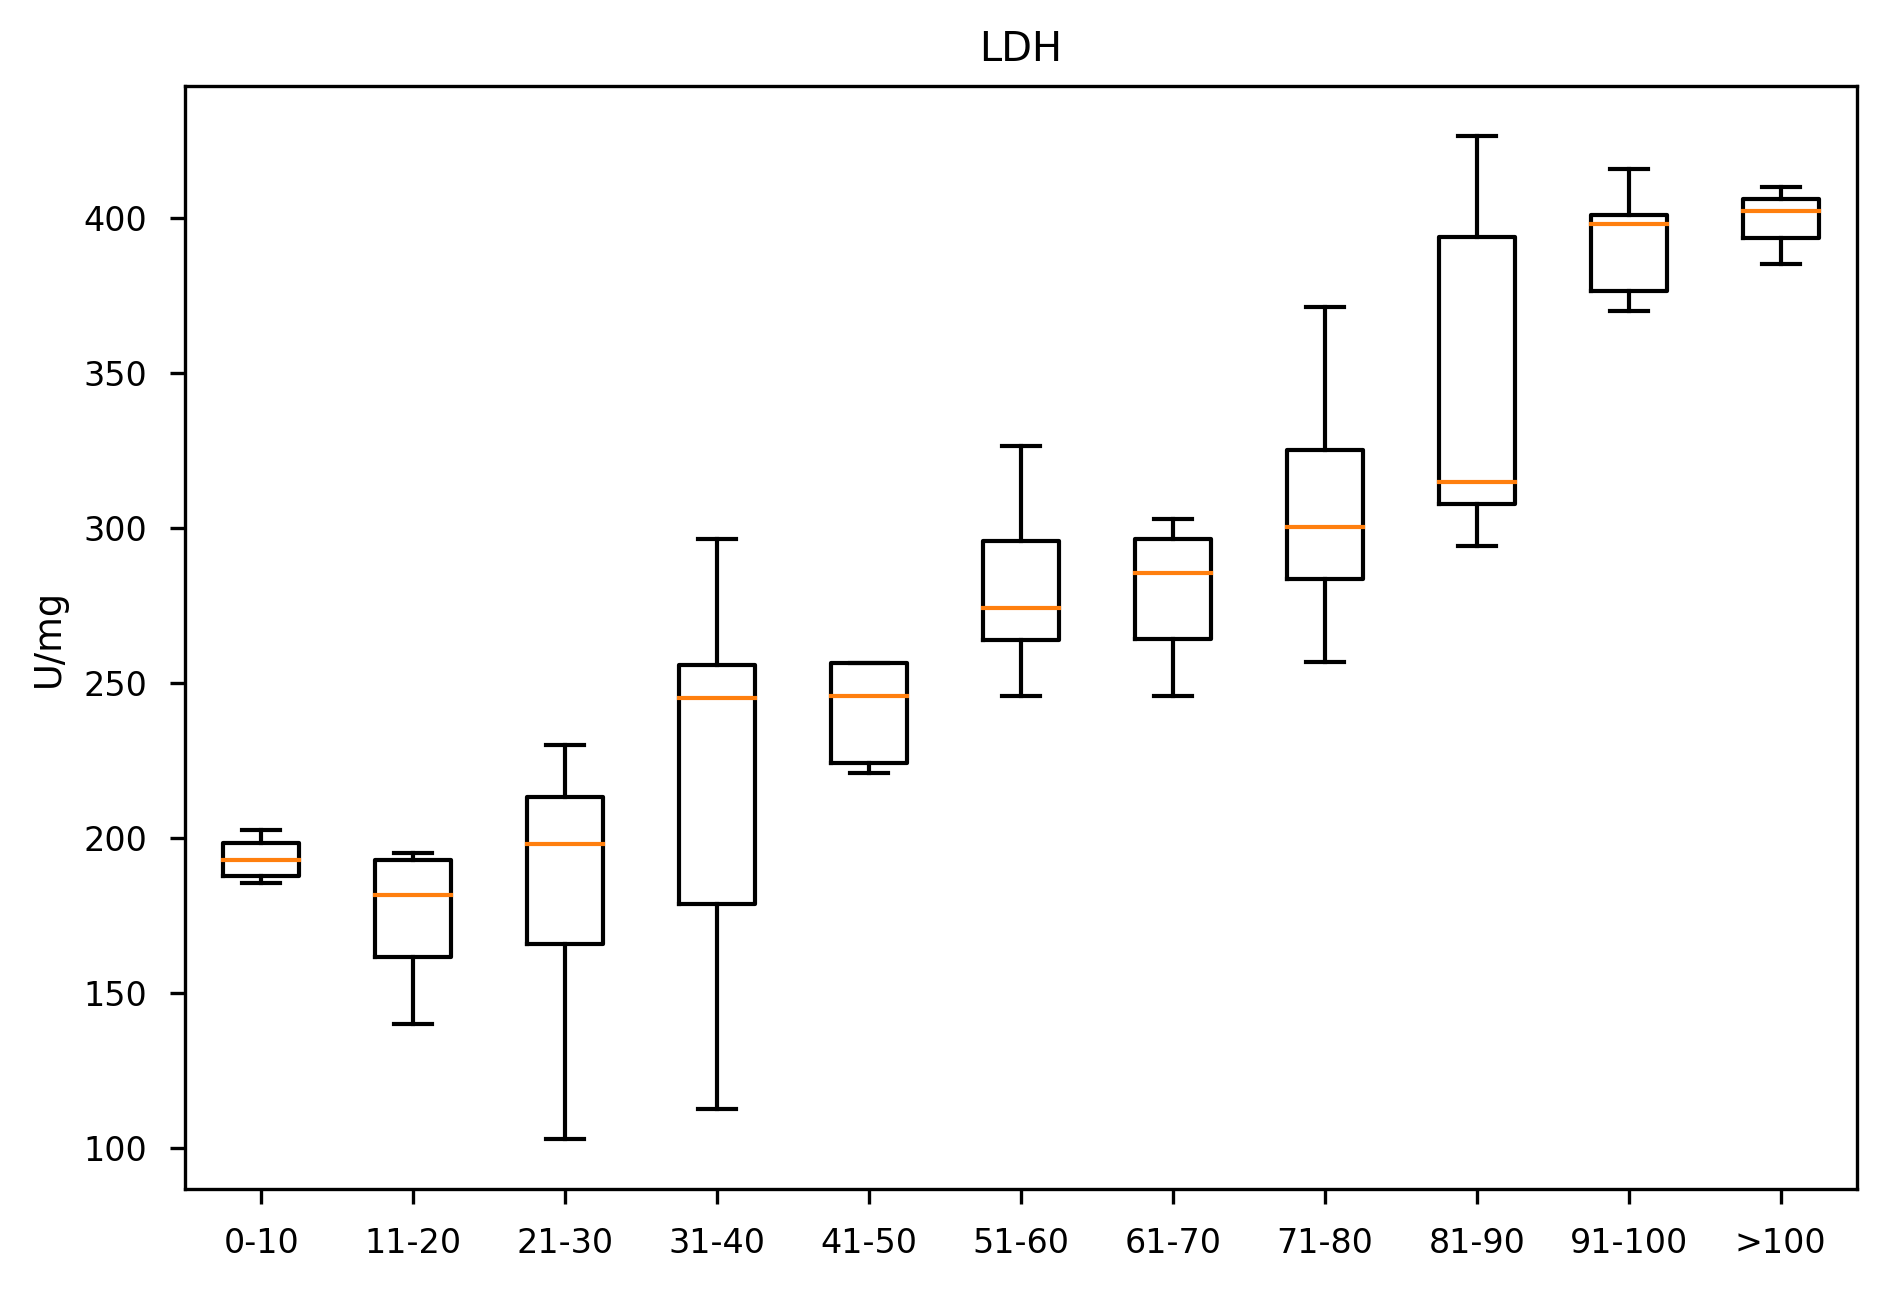

In [35]:
for i, c in enumerate(columns):
    # Exclude missing data
    _X = X[c].dropna()
    idx = _X.index
    
    # Make boxplot
    Xg = group_boxplot(_X.values, y.loc[idx].values)
    
    # Plot
    plt.figure(dpi=300)
    plt.boxplot(Xg)
    plt.title(c)
    plt.xticks(range(1,12), xticks, visible=True)
    plt.ylabel(units[c])
    plt.tight_layout()
    plt.savefig('../../images/aging_boxplot_'+c.replace('/','')+'.png');

# 2. Explore feature correlation

In [36]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import pearsonr
import seaborn as sns

def pearson(x,y):
    return pearsonr(x,y)[0]

def round_to_20(x):
    """round to the nearest two-decades"""
    return np.round(x / 20.0) * 20

def make_heatmap(df, tag, age):
    """
    df: nxd DataFrame
    tag: either CTRL or CCS
    """
    columns = df.columns#.drop(['age'])
    heat = pairwise_distances(df[columns].T.values, metric=pearson)
    
    plt.figure(figsize=(12, 8), dpi=300)
    sns.heatmap(heat, cmap=plt.cm.coolwarm, annot=True, vmax=1, vmin=-1)
    plt.yticks(np.arange(len(columns)), columns, rotation='horizontal')
    plt.xticks(np.arange(len(columns)), columns, rotation='vertical')
    if age.max()<100:
        plt.title('{}: [{} - {}]'.format(tag, int(round_to_20(age.min()))+1, int(round_to_20(age.max()))))
    else:
        plt.title('{}: > {}'.format(tag, int(round_to_20(age.min()))+1))
    
def make_heatmap_in_time(df, tag, age, save_output=False):
    """
    df: nxd DataFrame
    tag: either CTRL or CCS
    """
    ages = np.array([0, 20, 40, 60, 80, 110])
    
    for i in range(len(ages)-1):
        idx = np.where(np.logical_and(age >= ages[i],
                                      age < ages[i+1]))[0]
        
        idx = df.iloc[idx, :].index
        make_heatmap(df.loc[idx], tag, age.loc[idx].values)
        
        if save_output:
            plt.savefig('../../images/aging_heatmap_{}_{}.png'.format(tag, i))

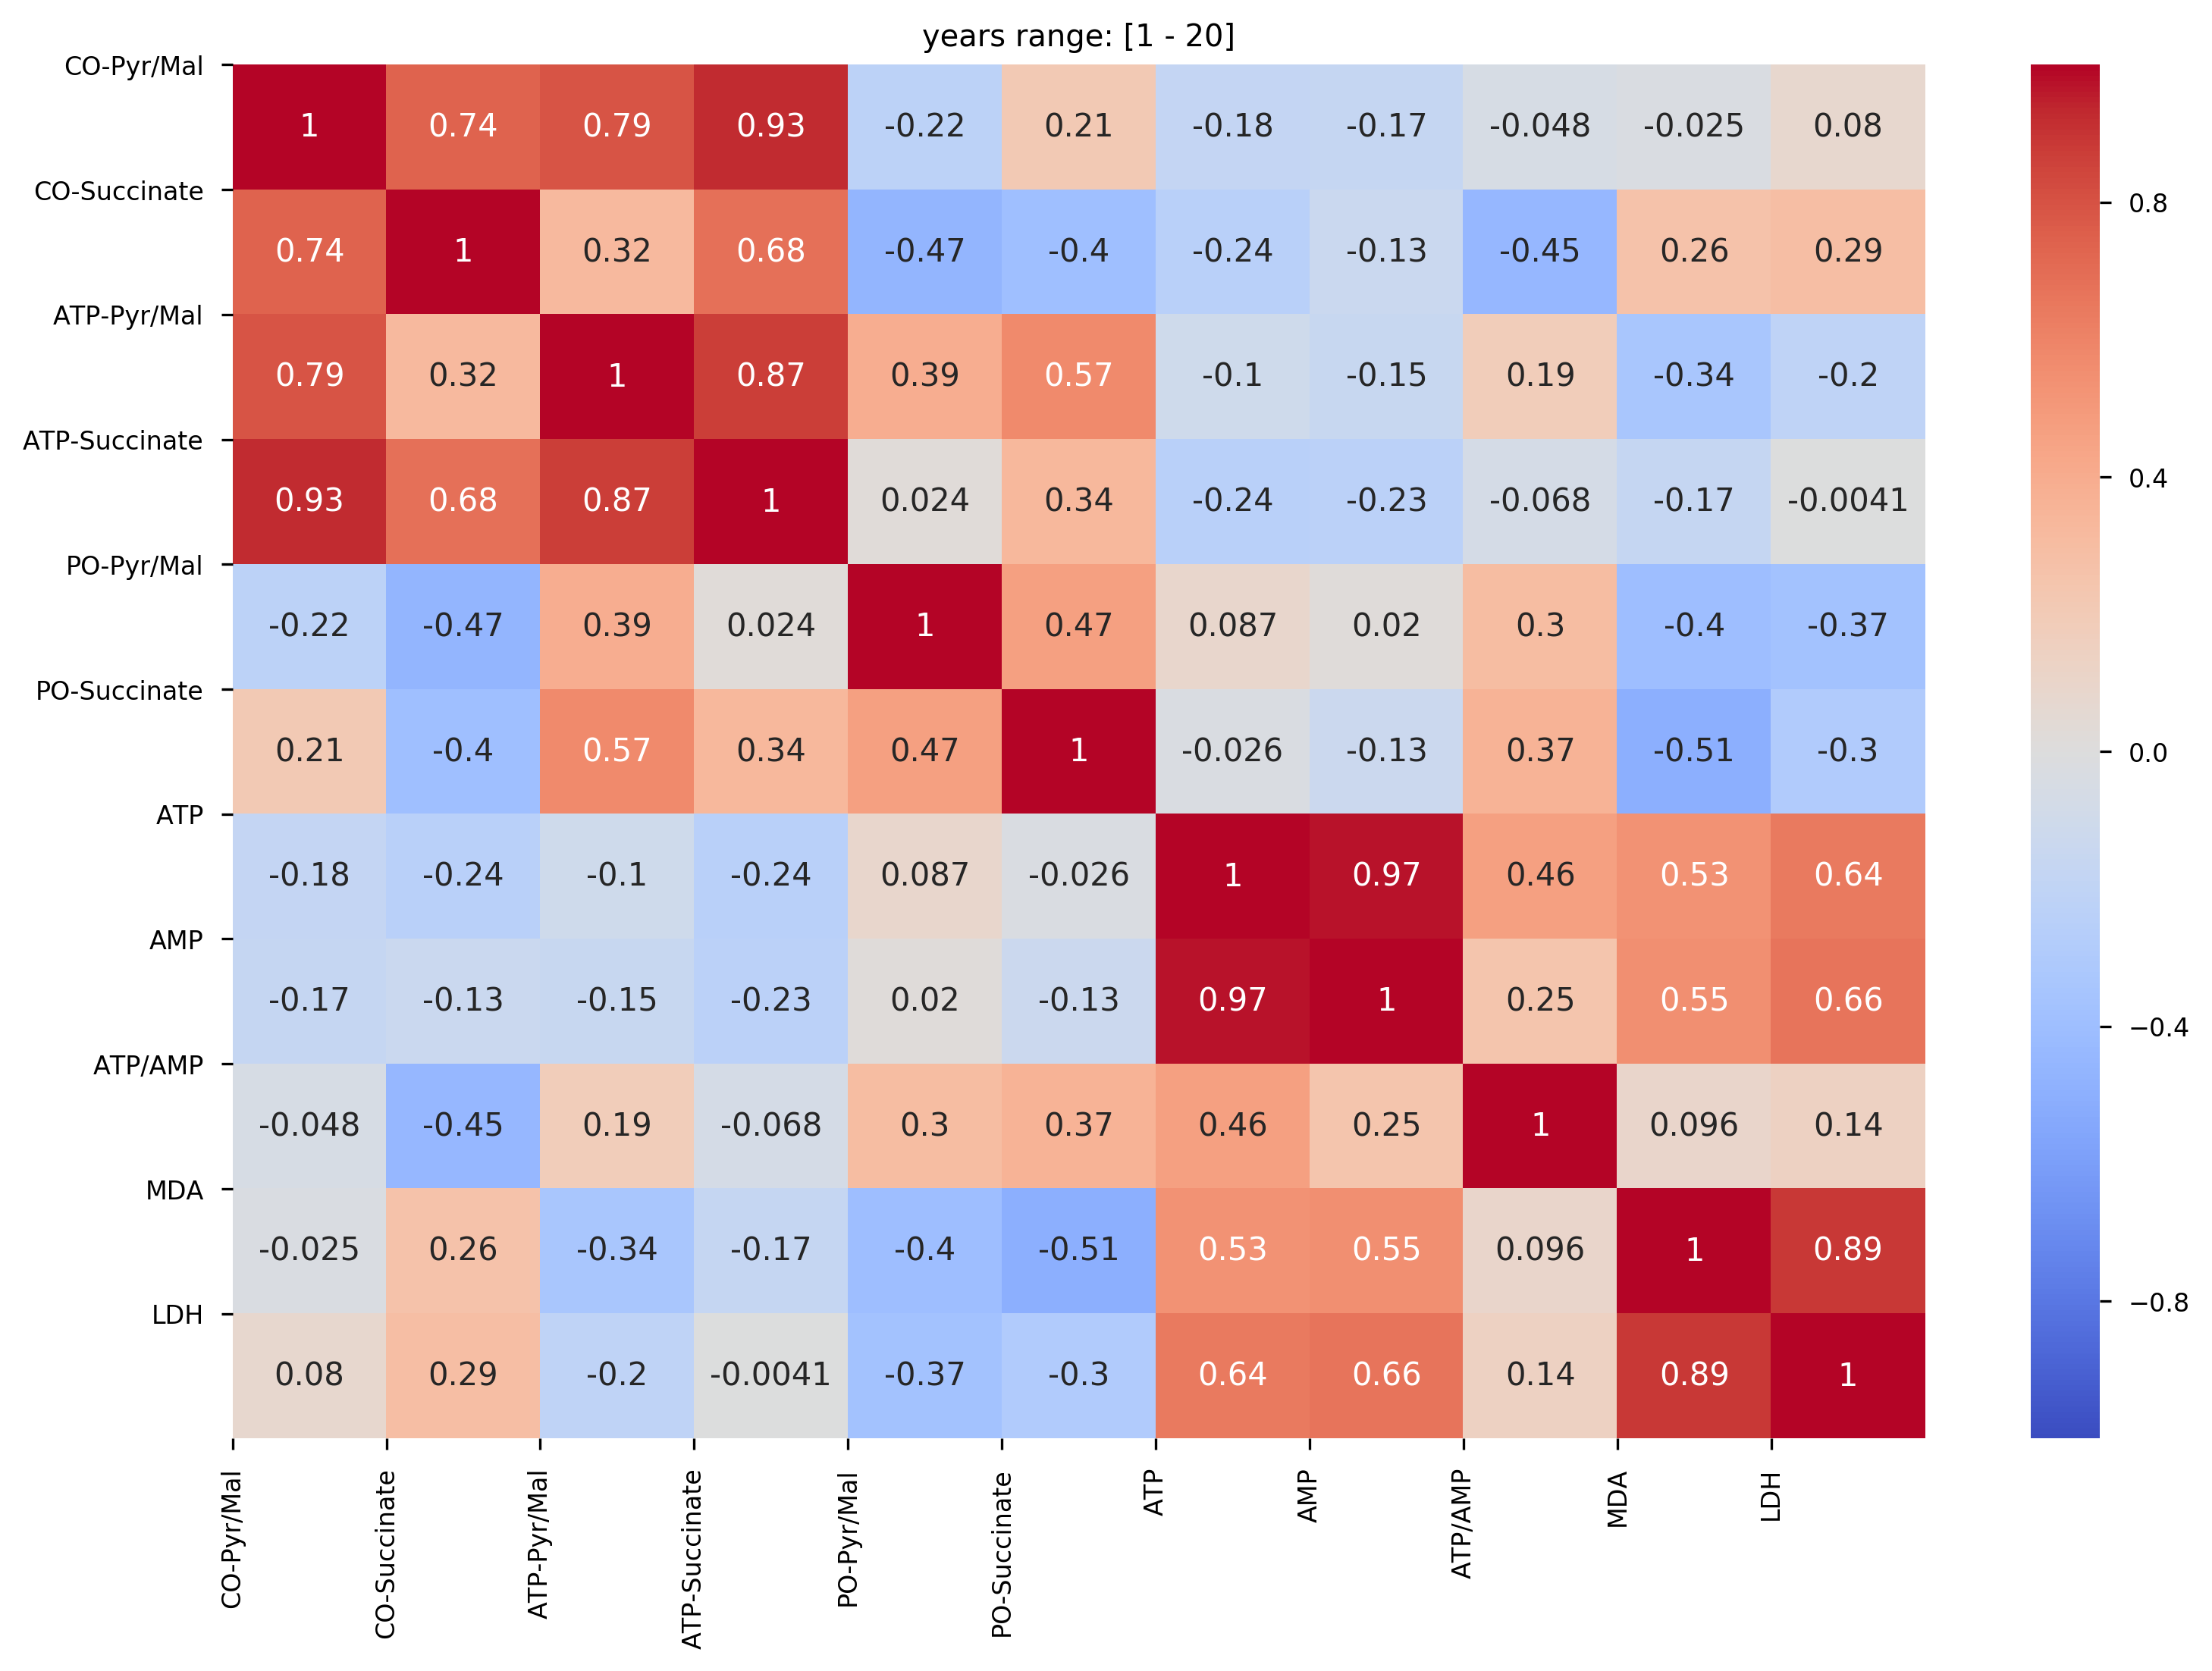

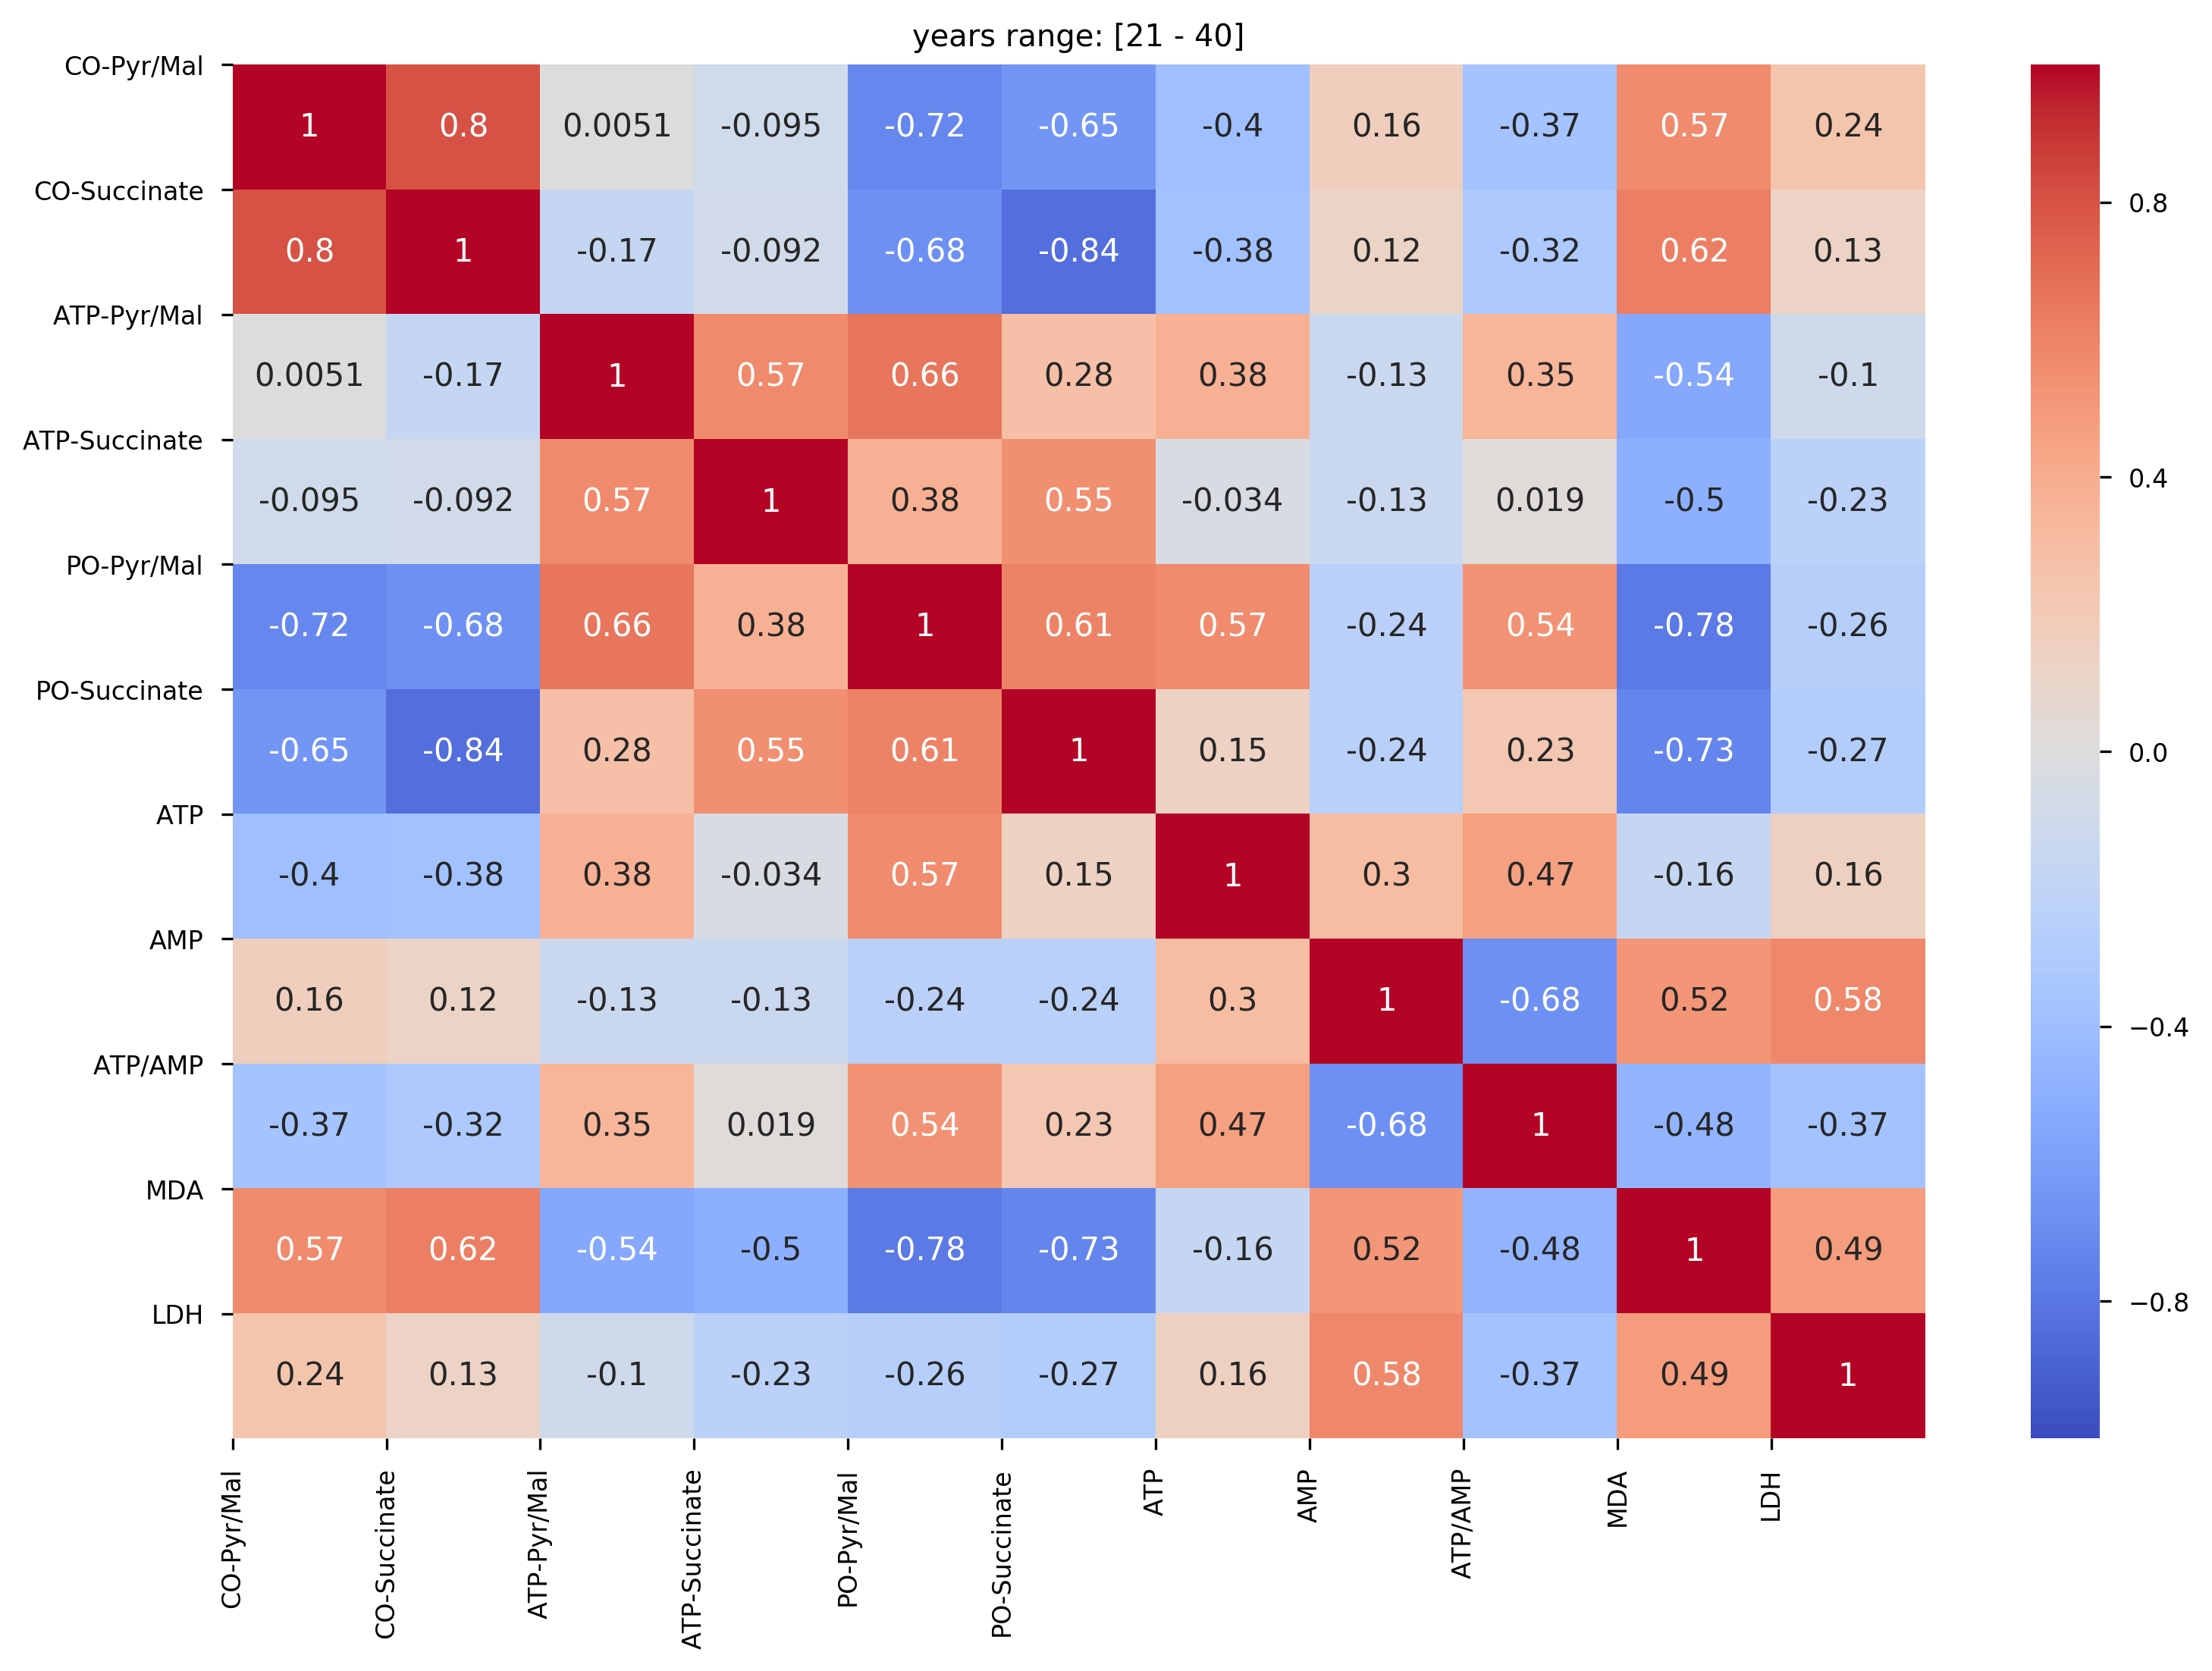

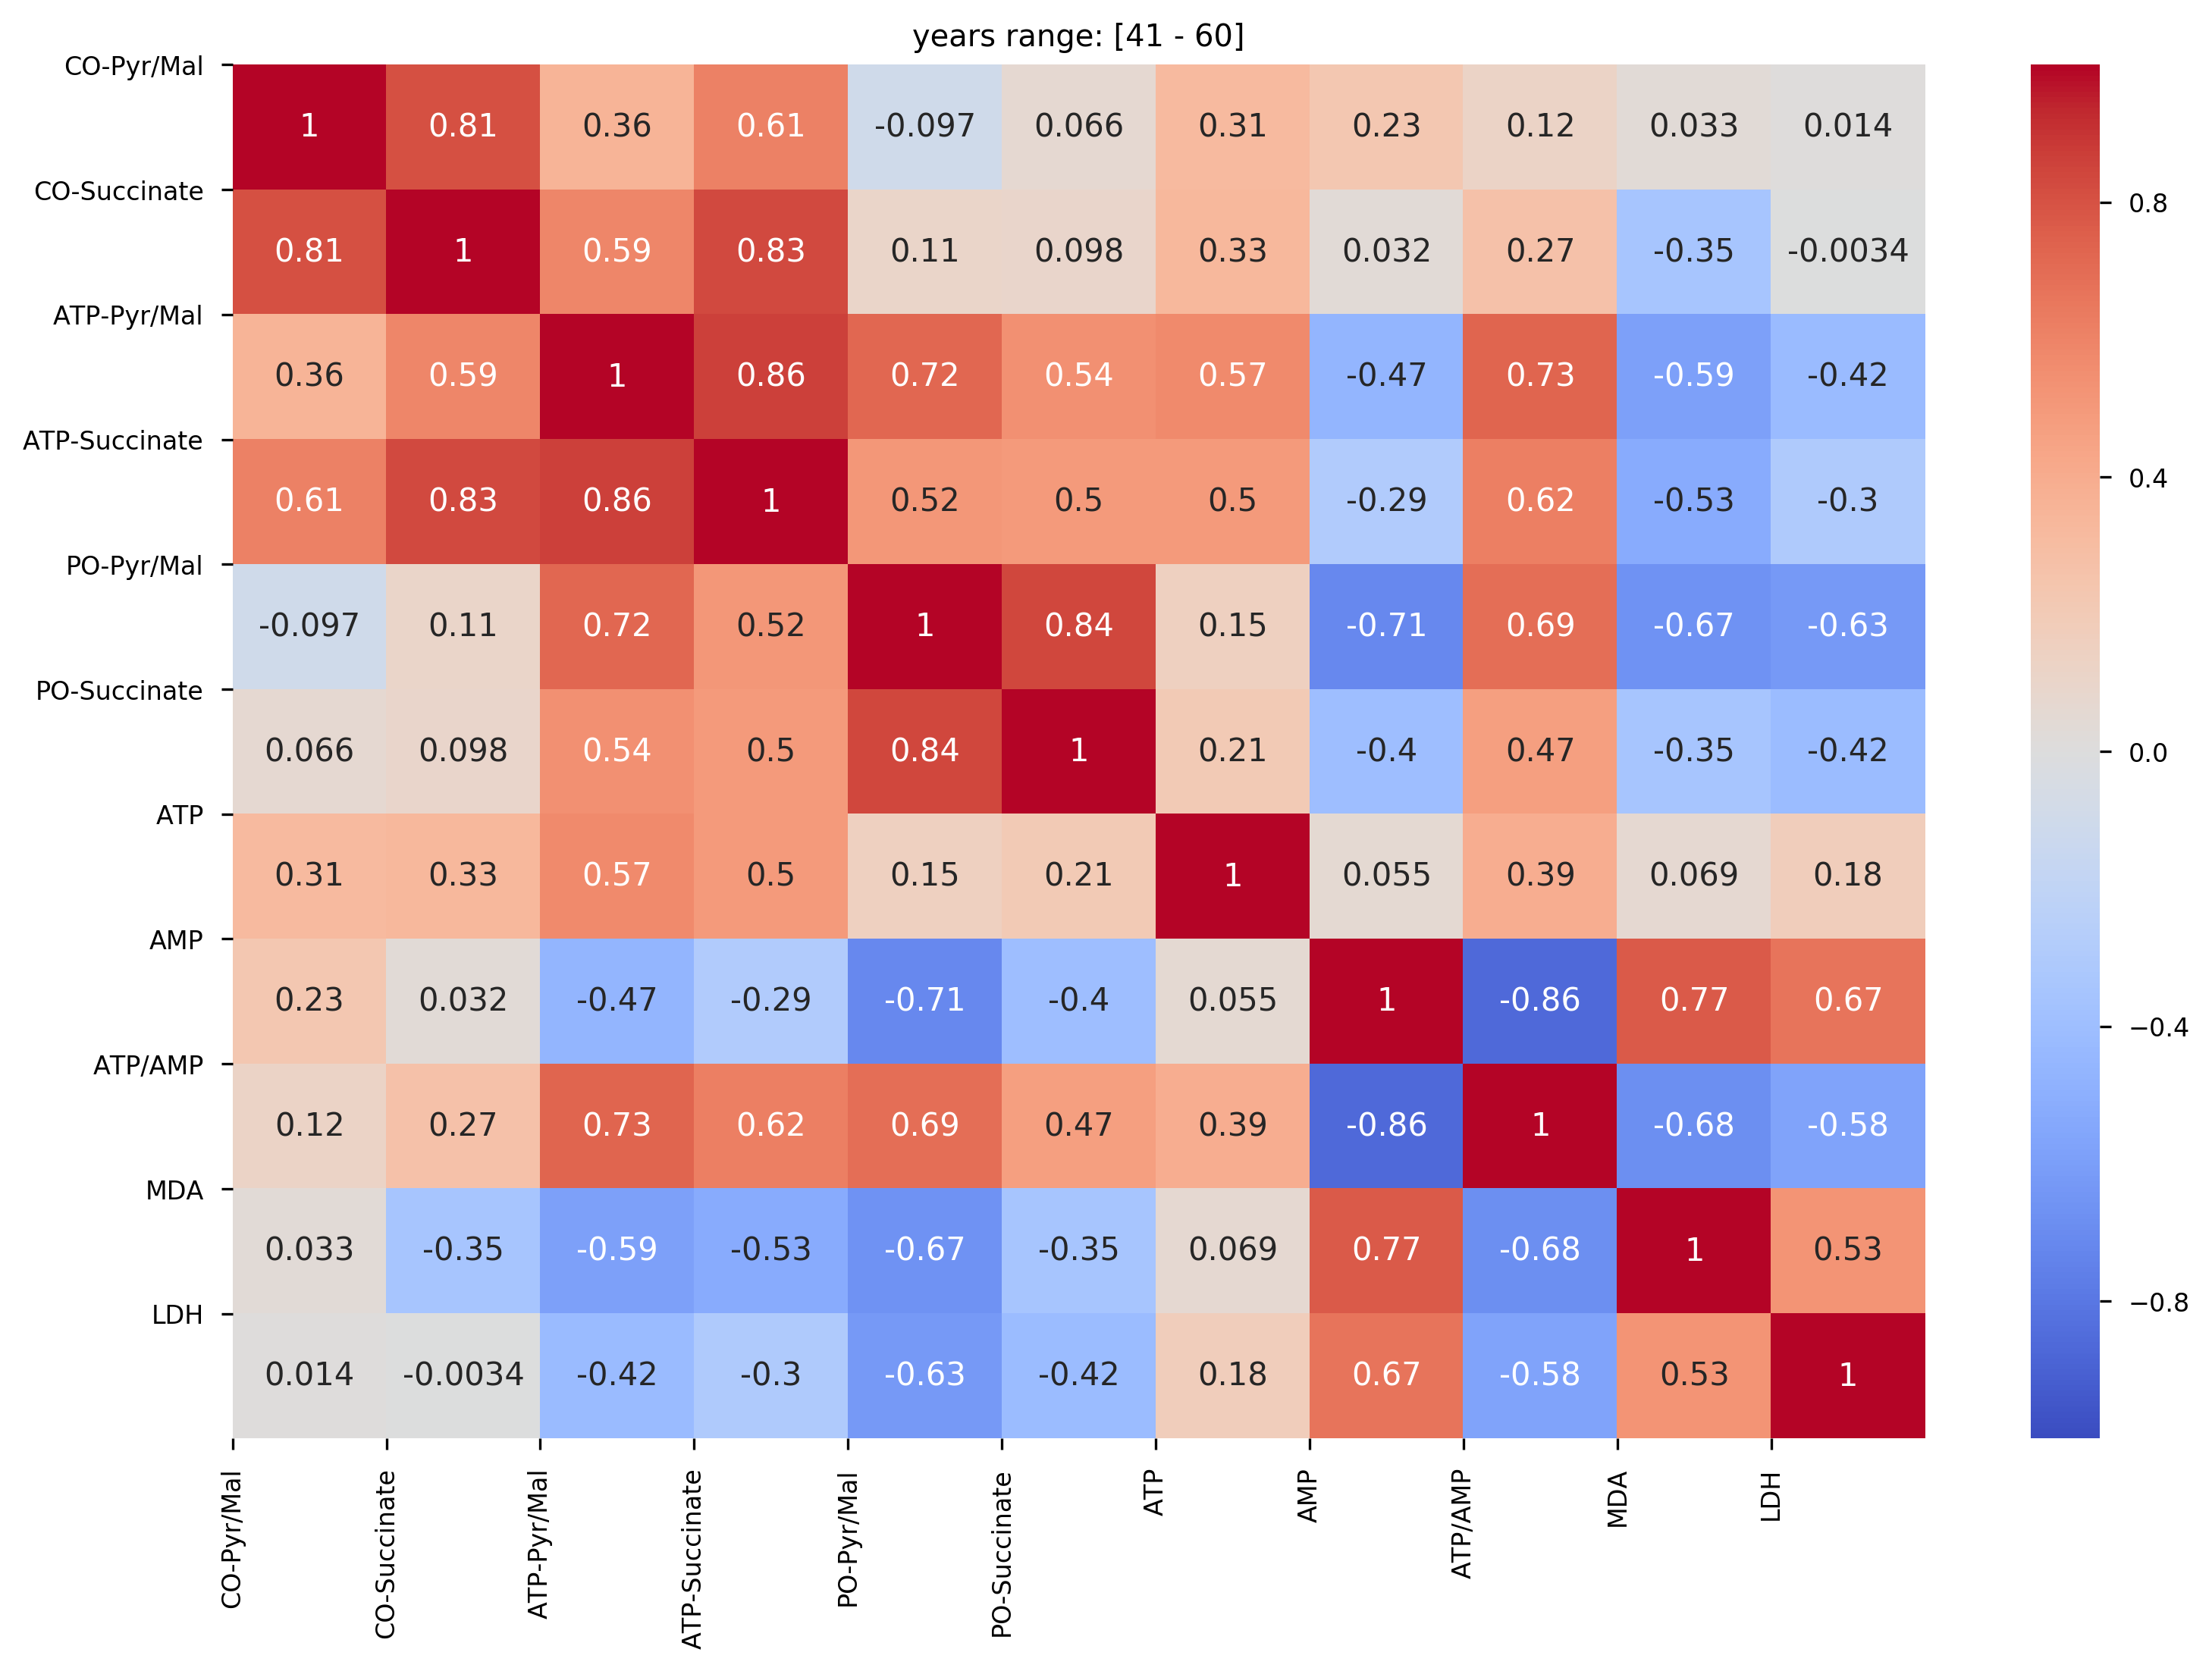

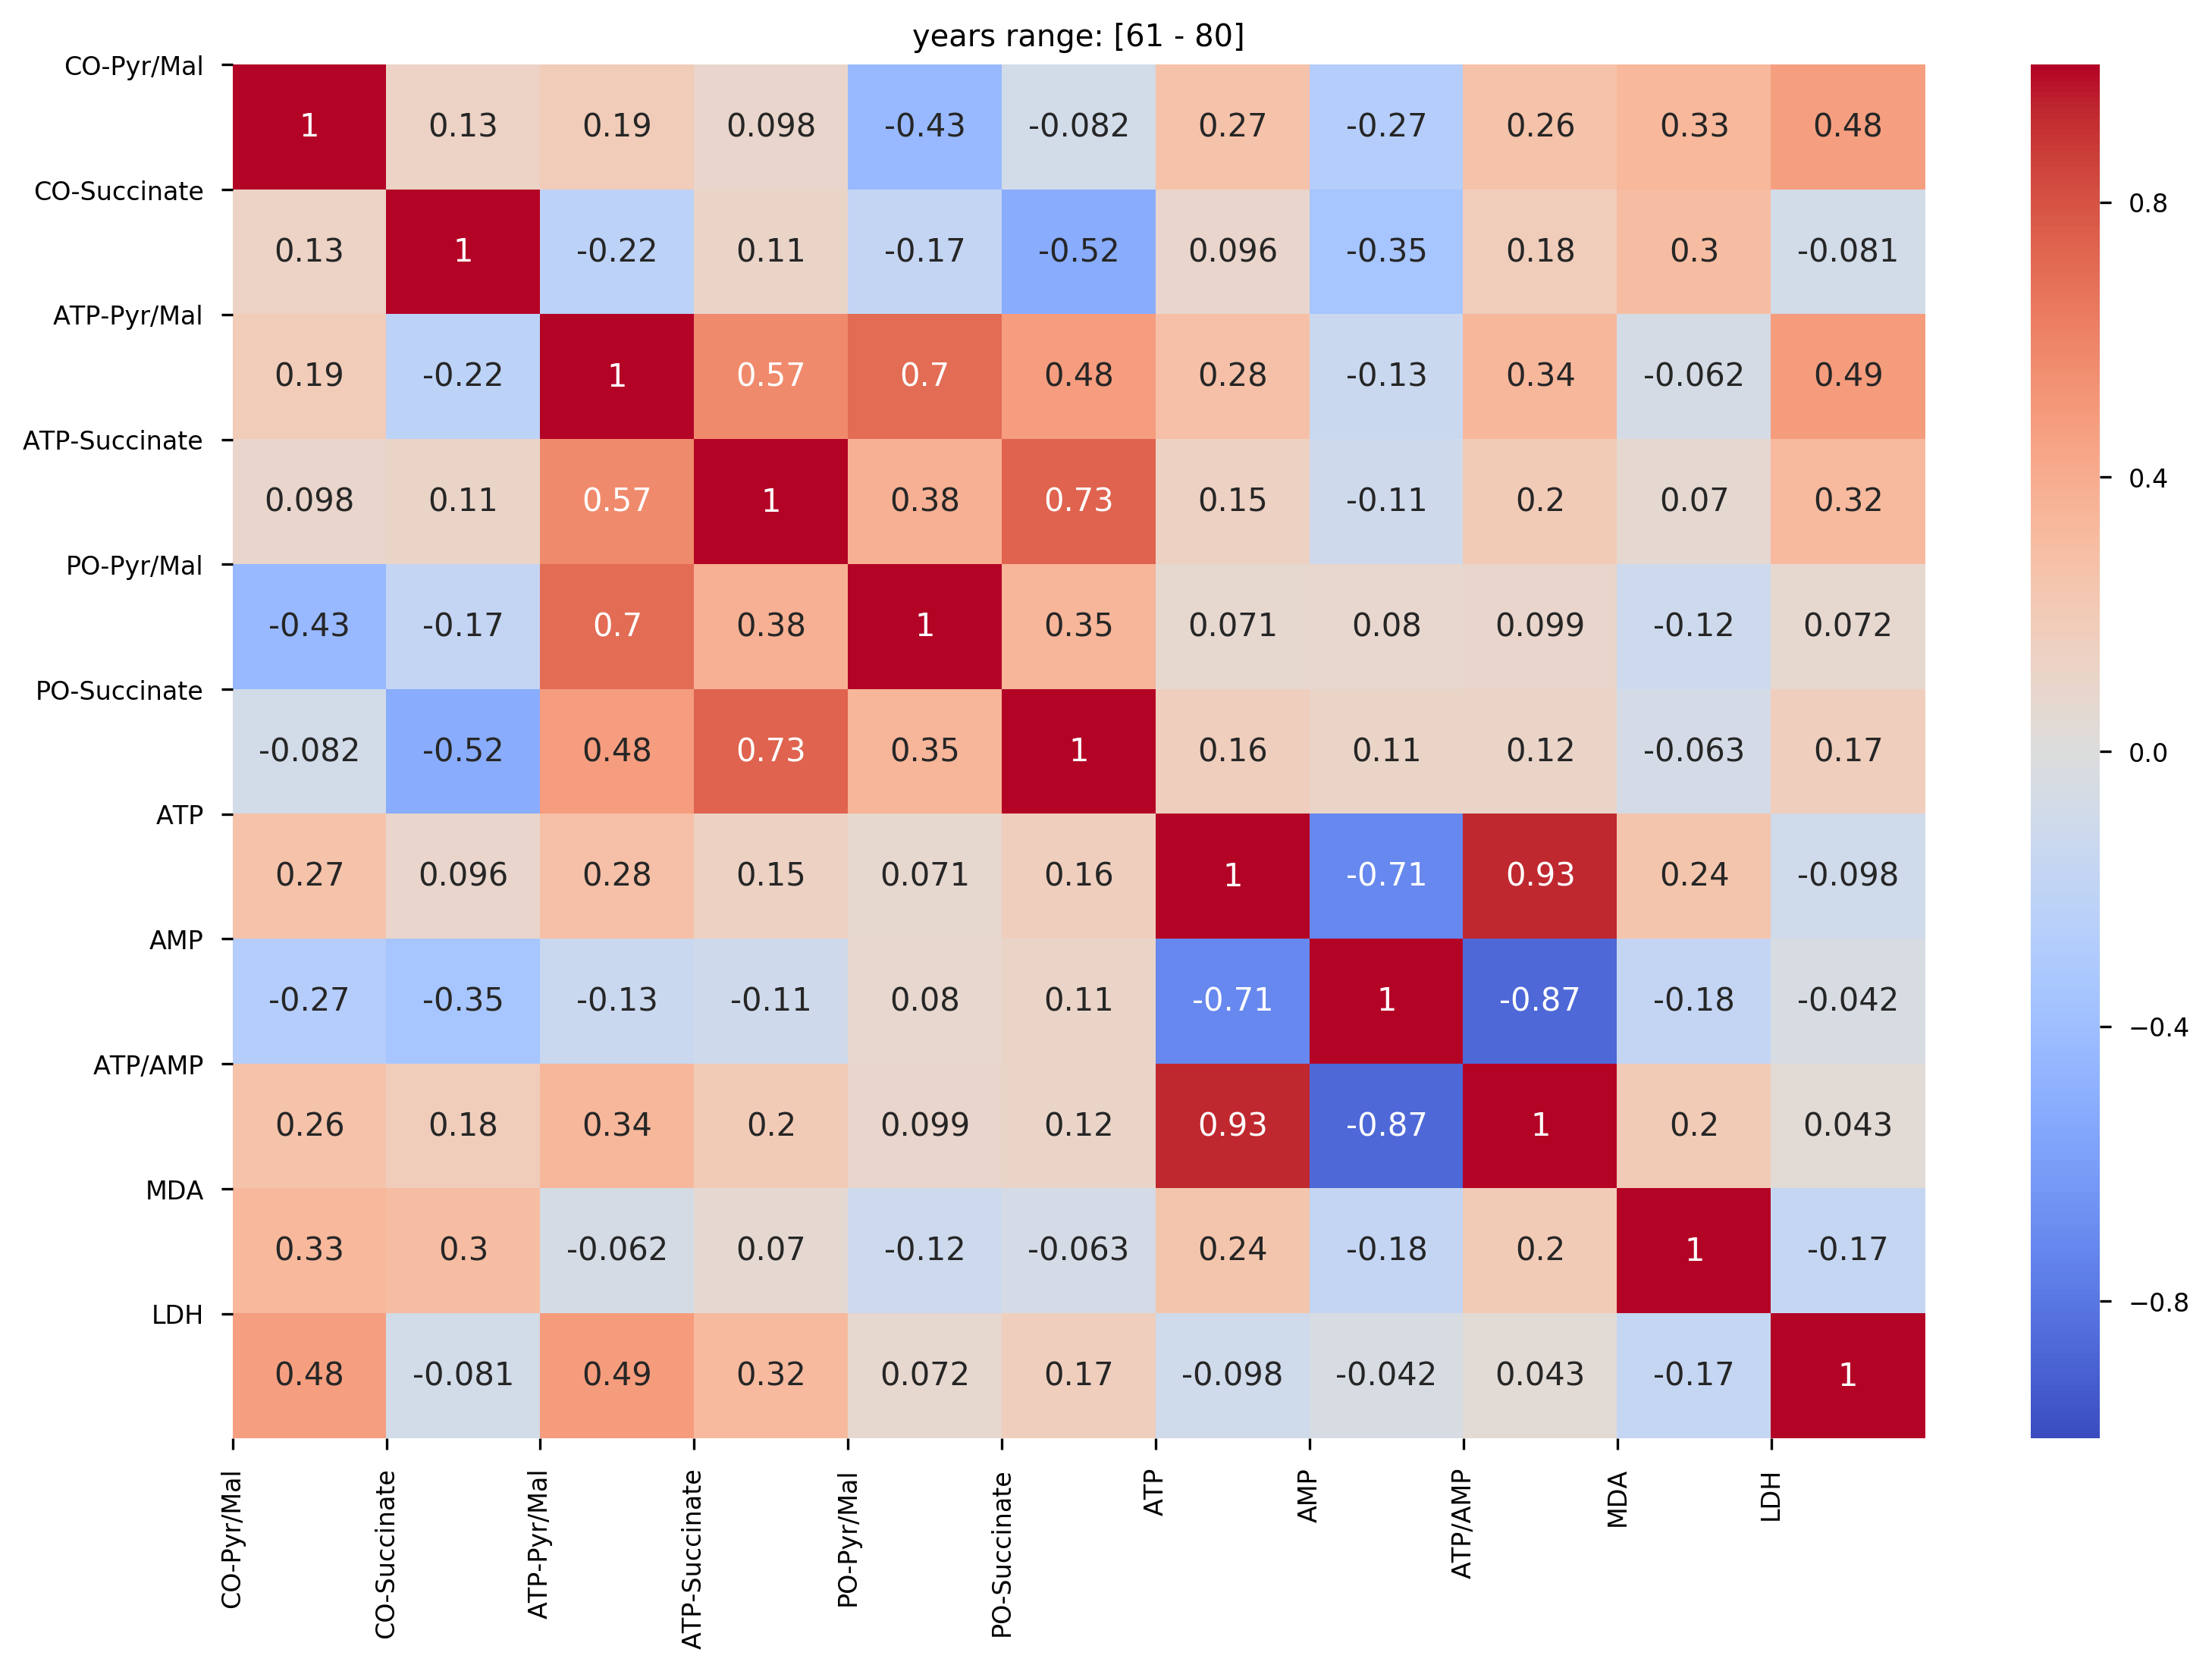

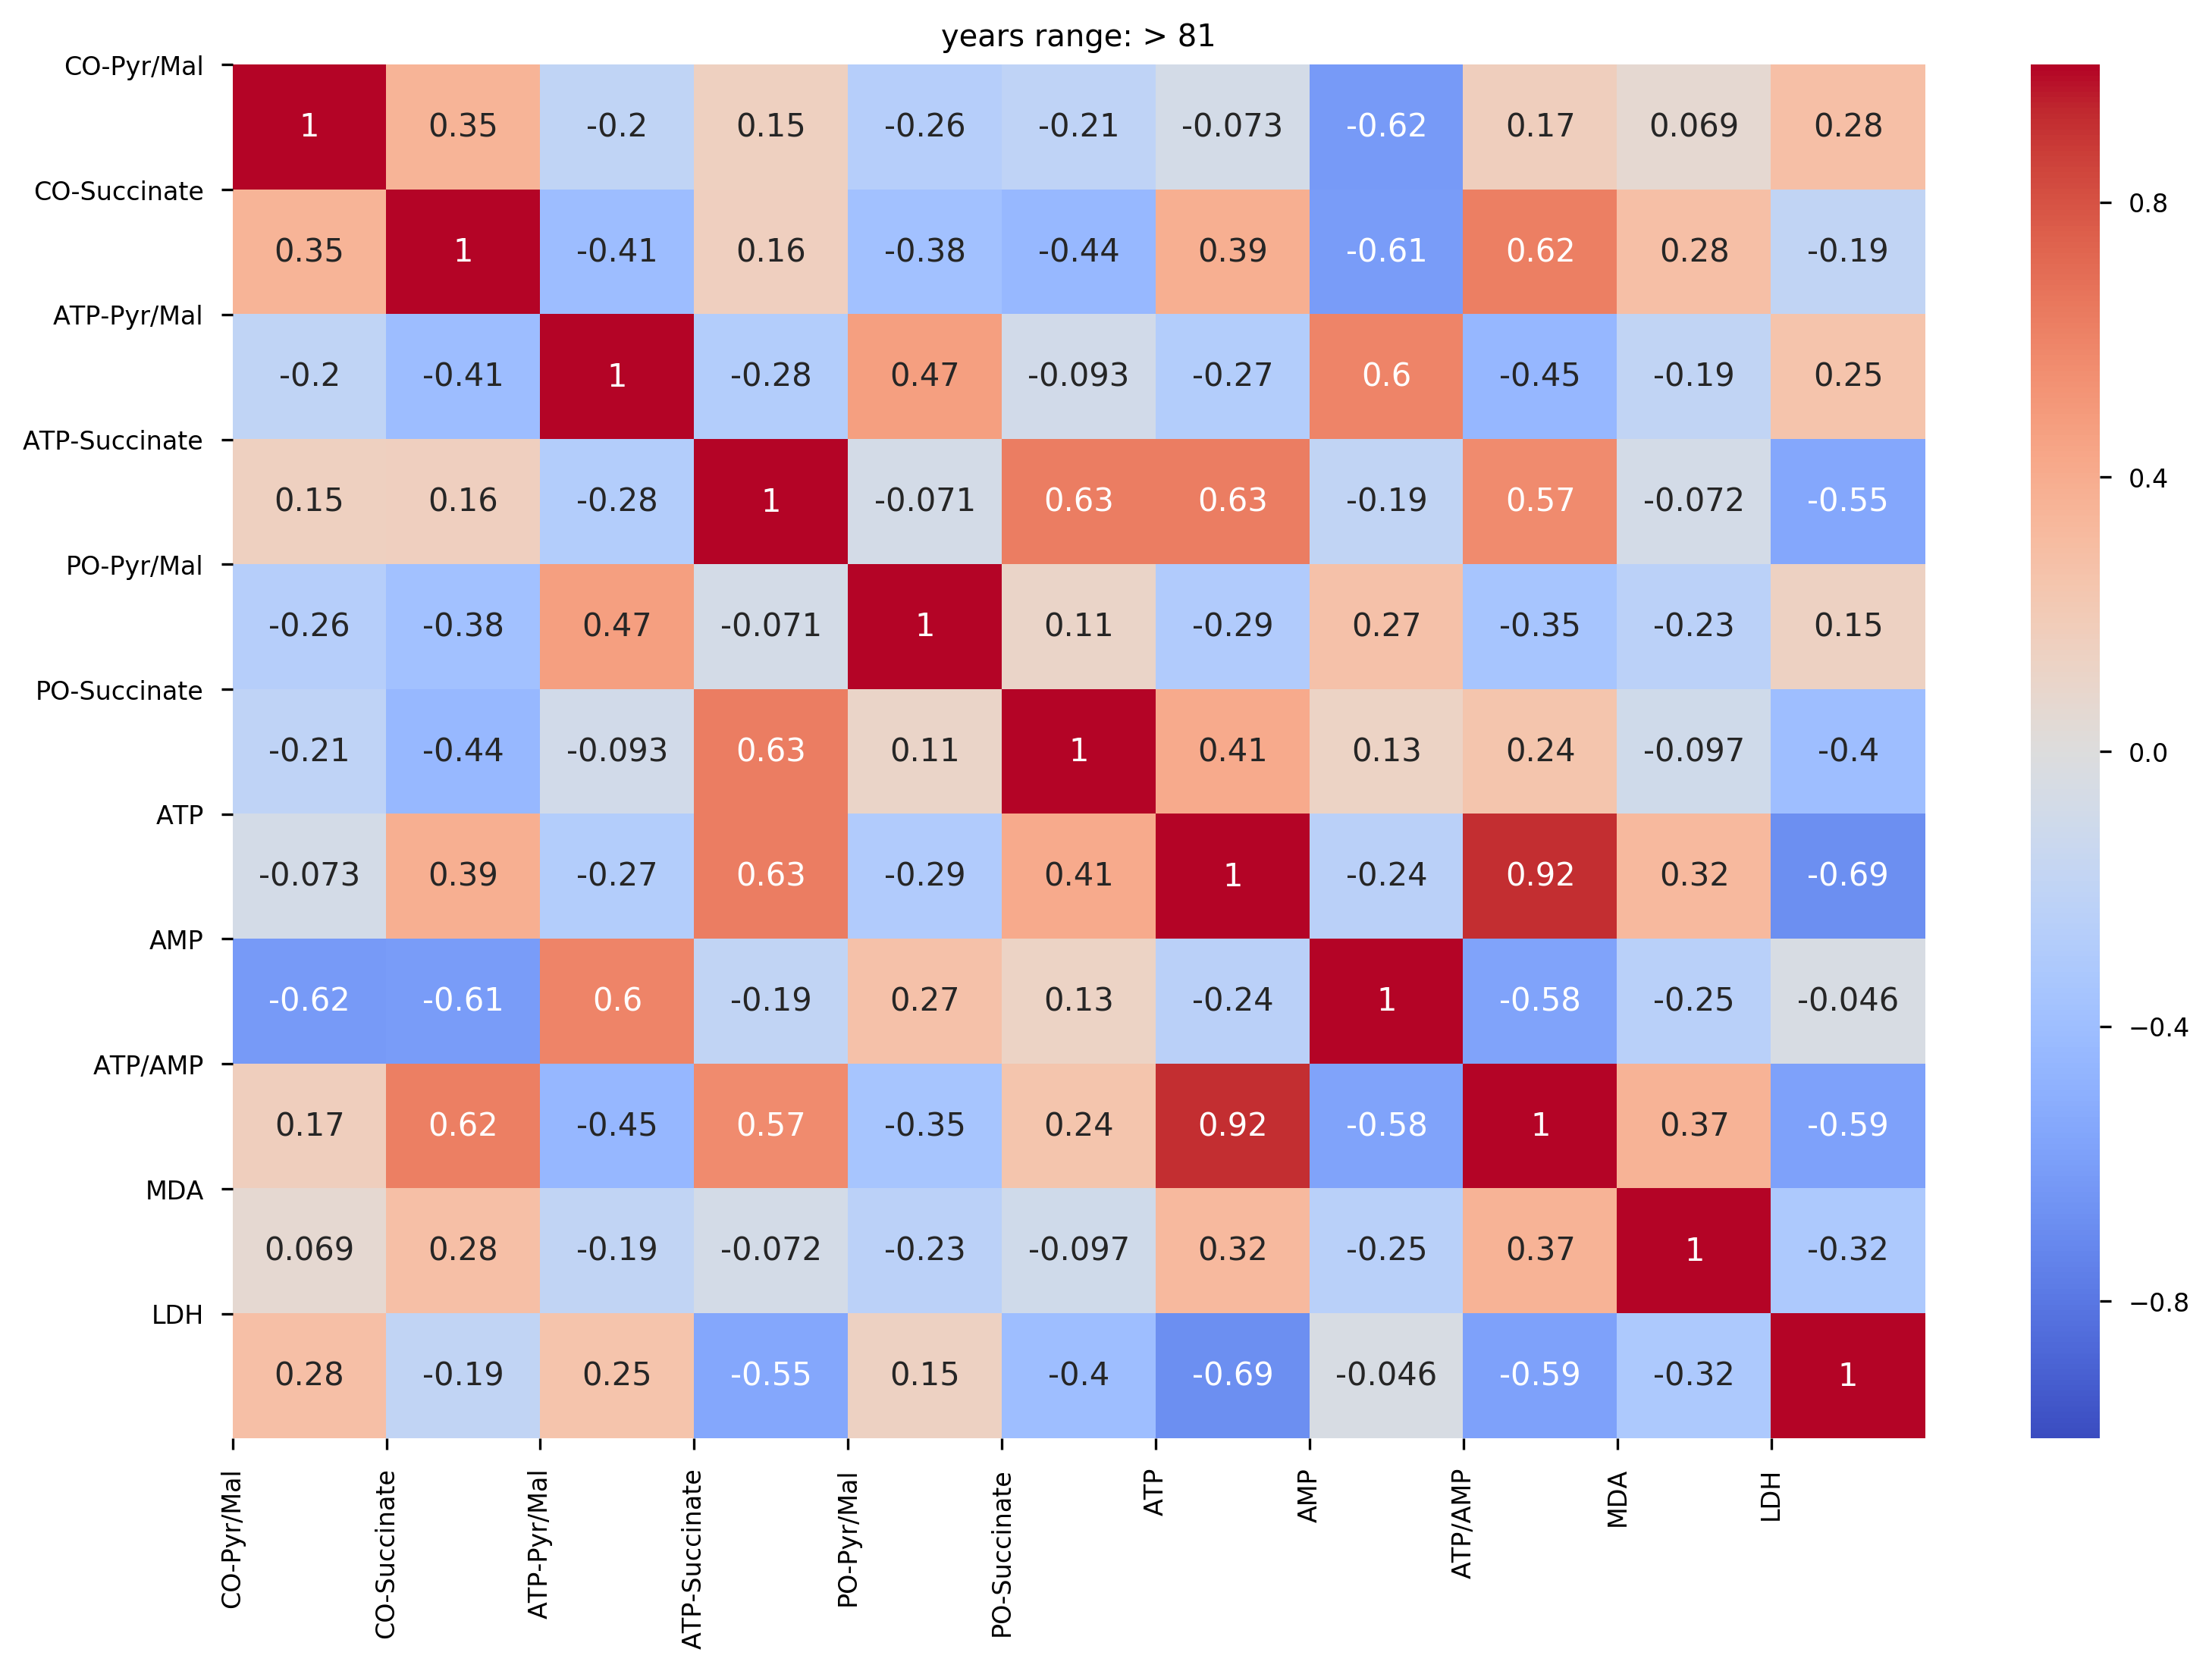

In [37]:
# Drop NaNs
_X = X.dropna()
idx = _X.index

make_heatmap_in_time(_X, 'years range', y.loc[idx], save_output=True)

# 3. Perform dimensionality reduction

In [102]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def make_3d_scatterplot(Xr, y, save_output=False):
    """
    Xr: dimensionality reduced data
    y: labels
    tag: 
    """
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111, projection='3d', axisbg='white')
    p = ax.scatter(Xr[:,0], Xr[:,1], Xr[:,2], c=y,
                   marker='o', cmap='YlOrRd', s=100, alpha=0.9)
    plt.colorbar(p)
    ax.w_xaxis.gridlines.set_lw(3)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    ax.set_xlabel(r'1$^{st}$ PC')
    ax.set_ylabel(r'2$^{nd}$ PC')
    ax.set_zlabel(r'3$^{rd}$ PC')
    
    ax.view_init(None, 75)
    
    plt.tight_layout()
    
    if save_output:
        plt.savefig('../../images/aging_PCA.png')

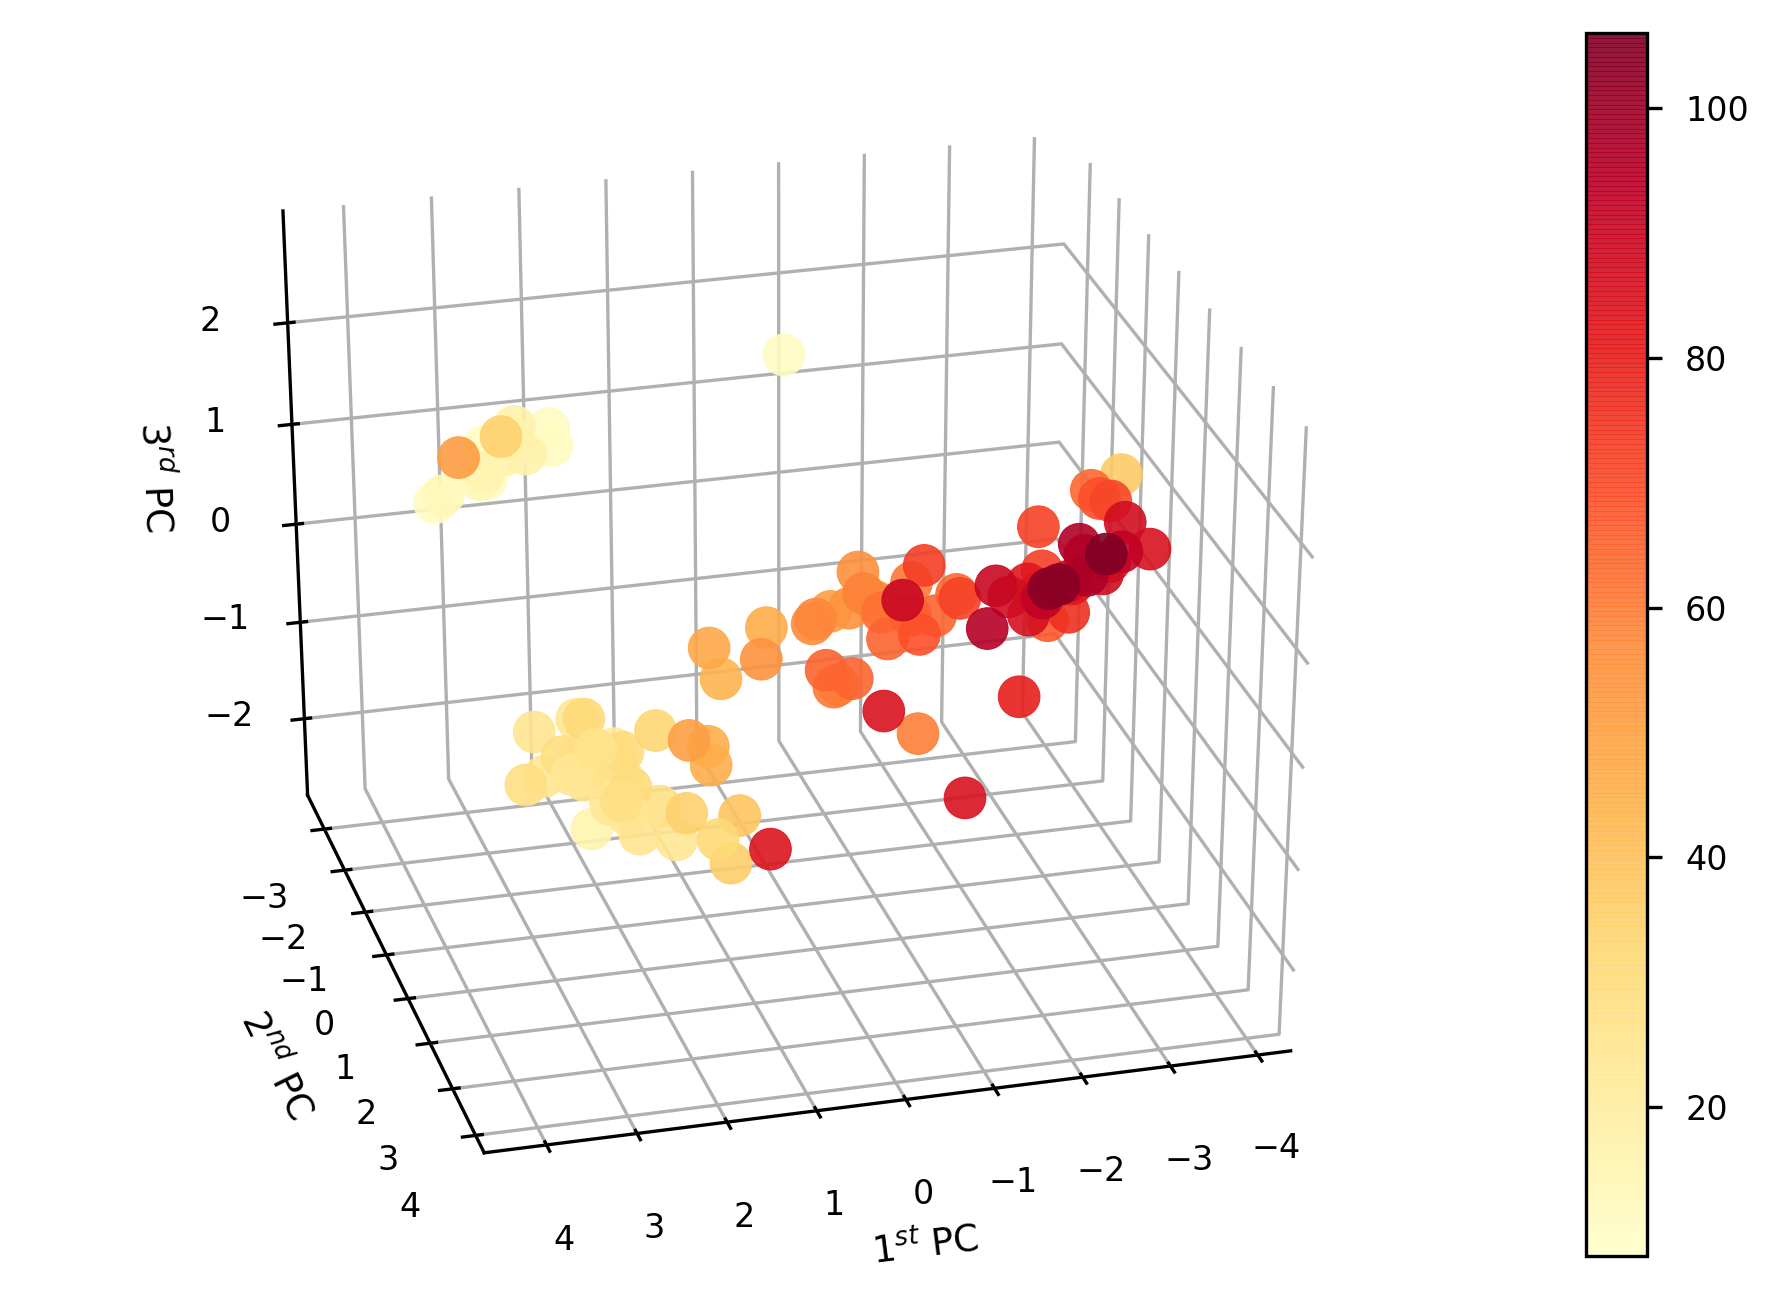

In [103]:
# Define pipeline
pipe = Pipeline([('preproc', StandardScaler()),
                  ('dimred', PCA(n_components=3))])

# Run PCA
Xr = pipe.fit_transform(_X.values)

# Make plot
make_3d_scatterplot(Xr,  y.loc[idx], save_output=True)